In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.api.types import is_numeric_dtype

In [150]:
!pip install tensorflow

In [151]:
import tensorflow as tf

In [152]:
!pip install keras

In [153]:
!pip install scikeras

In [154]:
import keras
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
# from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [155]:
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [156]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [157]:
!pip install shap
import shap

In [158]:
from google.cloud import bigquery

---------

### Authentication for working from Google Colab

In [159]:
# from google.colab import auth
# auth.authenticate_user()

---------

### Destination to save trained models

#### Google disk

In [160]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# project_folder_path = '/content/gdrive/Shareddrives/Magisterka/PROJEKT/'
# models_path = project_folder_path + '/models'

#### Vertex AI Jupyter Lab

In [161]:
data_analysis_folder_path = '../'
models_path = data_analysis_folder_path + '/models'

---------

### Connect to Bigquery service

In [162]:
import sys
sys.path.append("./../../")
from gcp_env import PROJECT_ID, LOCATION

In [163]:
project_id = PROJECT_ID # Fill project id
bqclient = bigquery.Client(project_id)

## Loading data

In [164]:
dataset_name = "twitbot_22_preprocessed_common_users_ids" #"twitbot_22_preprocessed"
users_table_name = "users_with_country"
BQ_TABLE_USERS = dataset_name + "." + users_table_name
table_id = project_id + "." + BQ_TABLE_USERS

In [165]:
job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=True
)

In [166]:
SQL_QUERY = f"""WITH 
  human_records AS (
    SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'human' 
    LIMIT 5000),
  bot_records AS (
  SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'bot' 
    LIMIT 5000)
  SELECT * FROM human_records 
    UNION ALL SELECT * 
    FROM bot_records 
    ORDER BY row_num;"""

users_df1 = bqclient.query(SQL_QUERY).to_dataframe()
users_df1 = users_df1.drop(['row_num'], axis=1)

In [167]:
# LIMIT RESULTS OPTIONS
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

In [168]:
num_bots = len(users_df1.loc[users_df1['label']=='bot'])       # bots number
num_humans = len(users_df1.loc[users_df1['label']=='human'])   # humans number

print("Number of real users: ", num_humans)
print("Number of bots: ", num_bots)

Number of real users:  5000
Number of bots:  5000


In [169]:
org_users_df = pd.DataFrame(users_df1).copy()
users_df2 = pd.DataFrame(org_users_df).copy()

#### Filter to have same number of record for each class - part I (second part after data analysis and reducing some of outliers)

In [170]:
def filter_df_for_balanced_classes(df, bot_label_value='bot', human_label_value='human'):
    new_df = pd.DataFrame()

    i = 0 # bots iter.
    j = 0 # humans iter.
    k = 0
    num_bots = len(df.loc[df['label']==bot_label_value])
    num_humans = len(df.loc[df['label']==human_label_value])
    max_num = min(num_bots, num_humans)
    for index, record in df.iterrows():
      if k < (2*max_num):
        if record['label']==bot_label_value and i < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          i += 1
          k += 1
        if record['label']==human_label_value and j < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          j += 1
          k += 1
            
    print("Number of bots: ", len(new_df.loc[new_df['label']==bot_label_value]))
    print("Number of human users: ", len(new_df.loc[new_df['label']==human_label_value]))
    
    return pd.DataFrame(new_df).copy();

In [171]:
users_df = filter_df_for_balanced_classes(users_df2)

Number of bots:  5000
Number of human users:  5000


## Data preparation

In [172]:
def drop_columns(df, columns):
    for column_name in columns:
      df = df.drop([column_name], axis=1)
    return df

In [173]:
def encode_not_numeric_columns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

#### Align values for bool columns

In [174]:
boolean_columns = ["verified", "protected", "withheld", "has_location", "has_profile_image_url", "has_pinned_tweet", "has_description"]

In [175]:
# Firstly align boolean columns values
for col_name in boolean_columns:
    users_df[col_name] = users_df[col_name].astype(bool)

column_to_remove = []
# Check unique values (some of subset can have only one unique value for some feature) if so it column will be removed from dataframe
for col_name in boolean_columns:
    uniq_val_list = users_df[col_name].unique()
    print("Column {:<24} {}".format(col_name, str(uniq_val_list)))
    if (len(uniq_val_list) < 2):
        column_to_remove.append(col_name)

Column verified                 [False  True]
Column protected                [False  True]
Column withheld                 [False]
Column has_location             [ True False]
Column has_profile_image_url    [ True False]
Column has_pinned_tweet         [False  True]
Column has_description          [ True False]


In [176]:
column_to_remove

['withheld']

In [177]:
# remove from bool columns:
for col_name in column_to_remove:
    boolean_columns.remove(col_name)
# remove from dataframe
users_df = drop_columns(users_df, column_to_remove)

### Encoding of non-numeric information which will be used by model

In [178]:
# Remap the values of the dataframe
for col_name in boolean_columns:
  users_df[col_name] = users_df[col_name].map({True:1,False:0})

# Remap label values human/bot for 0/1
label_col = "label"
users_df[label_col] = users_df[label_col].map({"human":0,"bot":1})


### Location mapping

#### Tried some supporting libs:
    - pycountry.countries.search_fuzzy: working not too good with some basic locations 
    - locationtagger: working not too good with some basic locations 
    - geograpy.get_place_context: chosen tool to map location to country
    
Chosen **geograpy3 lib** - mapping moved to preprocessing step - added new columns 'country' and 'country_numeric'

In [179]:
import json
 
with open('./../../data-preprocessing/scripts/users/countries_dict.json') as json_file:
    country_dict = json.load(json_file)

#### Null and NaN statistics

In [180]:
for col_name in users_df:
    count1 = pd.isnull(users_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
label: 0
username: 0
name: 0
created_at: 0
verified: 0
protected: 0
has_location: 0
location: 3476
has_profile_image_url: 0
has_pinned_tweet: 0
url: 0
followers_count: 0
following_count: 0
tweet_count: 0
listed_count: 0
has_description: 0
description: 0
descr_no_hashtags: 0
descr_no_cashtags: 0
descr_no_mentions: 0
descr_no_urls: 0
url_no_urls: 0
country: 0
country_numeric: 0


#### Extract some information from dataframe to new columns

##### Description length

In [181]:
users_df['descr_len'] = users_df['description'].apply(len).astype(float)

##### Account age (in days) (sice 16.03.2022) (dataset data collected during the 20/01-15/03/2022 period)

In [182]:
from datetime import datetime

In [183]:
def cal_days_diff(a,b):
    A = a.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    B = b.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    return (A - B).days

def convert_unixtime_to_datetime(a):
    return datetime.utcfromtimestamp(a)

In [184]:
base_date = datetime(2022, 3, 16)
users_df['account_age'] = users_df.apply(lambda x: cal_days_diff(base_date, convert_unixtime_to_datetime(x.created_at)), axis=1).astype(float)

#### Reduce unnecessary columns

In [185]:
users_reduced_df = pd.DataFrame(users_df).copy()
# columns_to_drop = ["id", "username", "name", "created_at", "location", "url", "description"]
columns_to_drop = ["username", "name", "created_at", "location", "url", "description", 'country']
users_reduced_df = drop_columns(users_reduced_df, columns_to_drop)
users_reduced_df

id  label  verified  protected  has_location  \
0     1428769922507751429      1         0          0             1   
1     1484544053572419585      0         0          0             1   
2      842202106324951040      1         0          0             1   
3     1447956502443069446      0         0          0             1   
4                21309002      1         0          0             1   
...                   ...    ...       ...        ...           ...   
9995           3275187061      0         0          0             1   
9996  1485289449487572996      1         0          0             0   
9997  1215382704876871680      0         0          0             1   
9998  1480725883820208131      1         0          0             0   
9999            407458156      0         0          0             1   

      has_profile_image_url  has_pinned_tweet  followers_count  \
0                         1                 0              2.0   
1                         1                 0              0.0   
2                         1                 0              3.0   
3                         1                 0              0.0   
4                         1                 0              3.0   
...                     ...               ...              ...   
9995                      1                 1            352.0   
9996                      1                 0              0.0   
9997                      1                 0            608.0   
9998                      1                 0              0.0   
9999                      1                 1            864.0   

      following_count  tweet_count  listed_count  has_description  \
0                41.0          1.0           0.0                1   
1                24.0          1.0           0.0                1   
2                22.0          4.0           0.0                0   
3                20.0          1.0           0.0                1   
4                42.0          2.0           0.0                0   
...               ...          ...           ...              ...   
9995            190.0       1094.0          18.0                1   
9996             34.0          0.0           0.0                1   
9997           1265.0       1095.0          11.0                1   
9998              5.0          0.0           0.0                0   
9999            346.0     153532.0          47.0                1   

      descr_no_hashtags  descr_no_cashtags  descr_no_mentions  descr_no_urls  \
0                   0.0                0.0                0.0            0.0   
1                   0.0                0.0                0.0            0.0   
2                   0.0                0.0                0.0            0.0   
3                   1.0                0.0                0.0            0.0   
4                   0.0                0.0                0.0            0.0   
...                 ...                ...                ...            ...   
9995                5.0                0.0                0.0            0.0   
9996                0.0                0.0                0.0            0.0   
9997                0.0                0.0                1.0            0.0   
9998                0.0                0.0                0.0            0.0   
9999                0.0                0.0                1.0            0.0   

      url_no_urls  country_numeric  descr_len  account_age  
0             1.0             81.0      160.0        208.0  
1             0.0            170.0       72.0         54.0  
2             0.0             16.0        0.0       1826.0  
3             0.0              1.0       85.0        155.0  
4             0.0             81.0        0.0       4773.0  
...           ...              ...        ...          ...  
9995          1.0             16.0      156.0       2440.0  
9996          0.0              1.0        5.0         52.0  
9997          1.0              1.0    

### Filter data, left column by feature importance based on SHAP results

In [186]:
shap_features = ['followers_count', 'tweet_count', 'following_count', 'account_age', 'descr_len', 'country_numeric']

In [187]:
users_reduced_df = users_df.copy()
users_reduced_df = users_df.filter(['label', 'id']+shap_features)
users_reduced_df

label                   id  followers_count  tweet_count  \
0         1  1428769922507751429              2.0          1.0   
1         0  1484544053572419585              0.0          1.0   
2         1   842202106324951040              3.0          4.0   
3         0  1447956502443069446              0.0          1.0   
4         1             21309002              3.0          2.0   
...     ...                  ...              ...          ...   
9995      0           3275187061            352.0       1094.0   
9996      1  1485289449487572996              0.0          0.0   
9997      0  1215382704876871680            608.0       1095.0   
9998      1  1480725883820208131              0.0          0.0   
9999      0            407458156            864.0     153532.0   

      following_count  account_age  descr_len  country_numeric  
0                41.0        208.0      160.0             81.0  
1                24.0         54.0       72.0            170.0  
2                22.0       1826.0        0.0             16.0  
3                20.0        155.0       85.0              1.0  
4                42.0       4773.0        0.0             81.0  
...               ...          ...        ...              ...  
9995            190.0       2440.0      156.0             16.0  
9996             34.0         52.0        5.0              1.0  
9997           1265.0        797.0      153.0              1.0  
9998              5.0         64.0        0.0              1.0  
9999            346.0       3781.0      135.0             41.0  

[10000 rows x 8 columns]

### Data type conversion (to float)

In [188]:
for (column_name, column_data) in users_reduced_df.iteritems():
    users_reduced_df[column_name] = users_reduced_df[column_name].astype(float)

### Data split for training, validation and testing

In [189]:
train_data, test_data = train_test_split(users_reduced_df, test_size=0.30, random_state=25, shuffle=True)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=25, shuffle=True)

### Create same dataframe for validation and test set to work with based on outliers analysis (done in later part)

In [190]:
val_data_wo_outliers = pd.DataFrame(val_data).copy()
test_data_wo_outliers = pd.DataFrame(test_data).copy()

### Describe trainig dataset

In [191]:
train_data.describe()

label            id  followers_count   tweet_count  \
count  7000.000000  7.000000e+03     7.000000e+03  7.000000e+03   
mean      0.503857  5.543646e+17     6.229971e+03  6.554910e+03   
std       0.500021  6.098100e+17     4.412925e+04  3.316229e+04   
min       0.000000  9.530000e+02     0.000000e+00  0.000000e+00   
25%       0.000000  2.792374e+08     3.300000e+01  2.200000e+01   
50%       1.000000  3.399836e+09     2.710000e+02  5.015000e+02   
75%       1.000000  1.207494e+18     1.565500e+03  3.310500e+03   
max       1.000000  1.495955e+18     1.730667e+06  1.184641e+06   

       following_count  account_age    descr_len  country_numeric  
count      7000.000000  7000.000000  7000.000000      7000.000000  
mean       1253.036286  2442.663000    84.592000        78.490000  
std        6121.951212  1640.465006    59.651674        95.261335  
min           0.000000    22.000000     0.000000         1.000000  
25%          74.000000   818.000000    23.000000         1.000000  
50%         269.000000  2407.000000    95.000000        18.000000  
75%         899.000000  3995.000000   143.000000       165.000000  
max      244195.000000  5724.000000   243.000000       250.000000

#### Describes training data for bots

In [192]:
train_data.loc[train_data['label']==1].describe()

label            id  followers_count    tweet_count  following_count  \
count  3527.0  3.527000e+03      3527.000000    3527.000000      3527.000000   
mean      1.0  6.799368e+17      2016.999716    2185.104338       770.499008   
std       0.0  6.153791e+17     19503.794857   11279.654017      4195.024713   
min       1.0  9.280410e+05         0.000000       0.000000         0.000000   
25%       1.0  8.678293e+08        14.000000       7.000000        41.000000   
50%       1.0  8.605276e+17        81.000000     127.000000       140.000000   
75%       1.0  1.285165e+18       410.000000    1086.000000       431.000000   
max       1.0  1.493160e+18    702018.000000  497641.000000    150720.000000   

       account_age    descr_len  country_numeric  
count  3527.000000  3527.000000      3527.000000  
mean   2060.185143    67.609300        64.706549  
std    1565.122289    62.244412        90.292452  
min      30.000000     0.000000         1.000000  
25%     604.000000     0.000000         1.000000  
50%    1776.000000    58.000000         1.000000  
75%    3446.500000   134.000000       106.000000  
max    5484.000000   243.000000       249.000000

#### Describes training data for humans

In [193]:
train_data.loc[train_data['label']==0].describe()

label            id  followers_count   tweet_count  following_count  \
count  3473.0  3.473000e+03     3.473000e+03  3.473000e+03      3473.000000   
mean      0.0  4.268398e+17     1.050845e+04  1.099266e+04      1743.076303   
std       0.0  5.768540e+17     5.918594e+04  4.526135e+04      7563.173323   
min       0.0  9.530000e+02     0.000000e+00  0.000000e+00         0.000000   
25%       0.0  1.374800e+08     1.570000e+02  1.700000e+02       159.000000   
50%       0.0  1.900708e+09     9.130000e+02  1.578000e+03       499.000000   
75%       0.0  1.017309e+18     3.610000e+03  6.601000e+03      1413.000000   
max       0.0  1.495955e+18     1.730667e+06  1.184641e+06    244195.000000   

       account_age    descr_len  country_numeric  
count  3473.000000  3473.000000      3473.000000  
mean   2831.087820   101.838756        92.487763  
std    1624.084521    51.457456        98.105472  
min      22.000000     0.000000         1.000000  
25%    1343.000000    63.000000         1.000000  
50%    3094.000000   115.000000        43.000000  
75%    4342.000000   149.000000       236.000000  
max    5724.000000   181.000000       250.000000

# Data analysis

In [194]:
def get_dataframe_real_indexes(df, outliers_index_list):
    real_all_indexes = train_data.loc[train_data['label']==1].index
    oder_indexes = np.arange(len(real_all_indexes)) 

    indexes_df = pd.DataFrame({'real_index' : real_all_indexes, 'order_index' : oder_indexes})
    return list(indexes_df[indexes_df.order_index.isin(outliers_index_list)]['real_index'])

In [195]:
def outliers_KNN(data, column_name, n_neighbors=10, radius=5, title="", r1=48, r2=90, w=900, h=500, ydtick=2, xdtick=2, nbins=20,  th = 0.9):

    np.set_printoptions(threshold=np.inf)

    # create model
    nbrs = NearestNeighbors(n_neighbors = n_neighbors, radius=radius)
    # fit model
    data_2d = [ [ 0., x] for x in data[column_name].values]
    nbrs.fit(data_2d)

    neighbors_and_distances = nbrs.kneighbors(data_2d)
    distances = neighbors_and_distances[0]
    neighbors = neighbors_and_distances[1]
    # print(neighbors_and_distances[1])

    plt.figure(figsize=(15, 7))
    # plt.plot(distances.mean(axis=1))

    distances = pd.DataFrame(distances)
    distances_mean = pd.DataFrame(distances).mean(axis =1)
    # distances_mean.describe()
    
    outliers_index = np.where(distances_mean > th) 
    outliers_index = list(outliers_index)[0]
    outliers_index = [outliers_index[i] for i in range(len(outliers_index))]
    outliers_index_with_column_name = [[indx, data[column_name].values[indx]] for indx in outliers_index]
    outliers_index_sorted_by_column_name = sorted(outliers_index_with_column_name,key=lambda x: x[1])

    outliers = list(dict(outliers_index_sorted_by_column_name).values())
    outliers_indexes = list(dict(outliers_index_sorted_by_column_name).keys())

    print("Number of outliers: ", len(outliers))

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    trace1 = go.Histogram(
            x=data[column_name],
            name=column_name,
            nbinsx=nbins,
            opacity=0.7,
    )
    trace2 = go.Histogram(
        x=outliers,
        nbinsx=nbins,
        # histnorm='density',
        name='outliers',
        opacity=0.7
    )

    traces = [trace1, trace2]
    layout = go.Layout(barmode='overlay')
    # layout = go.Layout()
    fig = go.Figure(data=traces, layout=layout)
    fig.update_layout(
        title_text=title, # title f plot
        xaxis_title_text='value', # xaxis label
        yaxis_title_text='frequency', # yaxis label
        bargap=0.05,
        bargroupgap=0.05
    )

    # fig.update_xaxes(dtick=xdtick, range =[r1,r2])
    # fig.update_yaxes(dtick=ydtick)
    fig.update_layout(
        width=w,
        height=h)
    fig.show()
    
    return get_dataframe_real_indexes(data, outliers_index)

## Distribution of label class in training, validation and test set

In [196]:
stack_data = {'Set': ['Training data', 'Validation data', 'Test data', 'Training data', 'Validation data', 'Test data'],
              'Label': ['Bot', 'Bot', 'Bot', 'Human', 'Human', 'Human'],
              'Freq': [len(train_data.loc[train_data['label']==1]), 
                       len(val_data.loc[val_data['label']==1]), 
                       len(test_data.loc[test_data['label']==1]),
                       len(train_data.loc[train_data['label']==0]), 
                       len(val_data.loc[val_data['label']==0]), 
                       len(test_data.loc[test_data['label']==0])]}
sdf = pd.DataFrame(stack_data)
sdf

Set  Label  Freq
0    Training data    Bot  3527
1  Validation data    Bot   743
2        Test data    Bot   730
3    Training data  Human  3473
4  Validation data  Human   757
5        Test data  Human   770

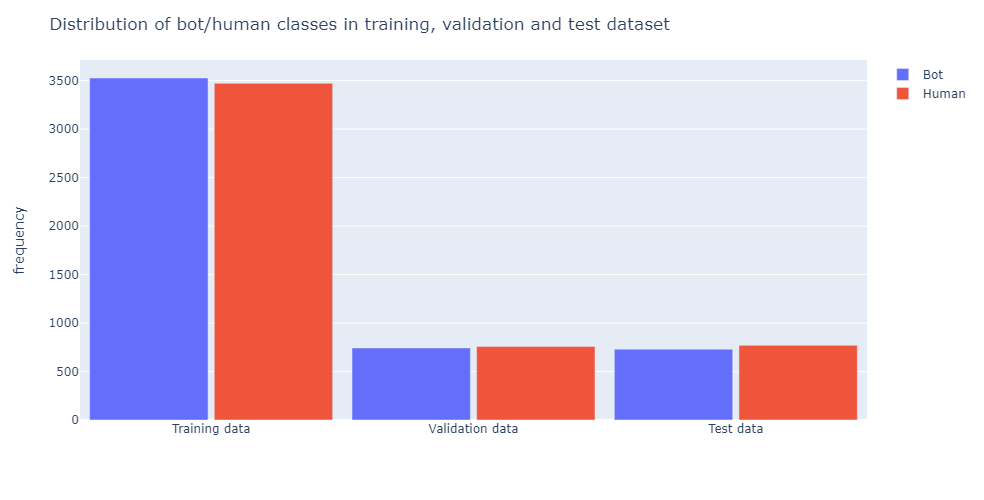

In [197]:
fig = px.bar(sdf, x="Set", y="Freq",
             color="Label", hover_data=['Label'],
             barmode = 'group')
fig.update_layout(
    title_text='Distribution of bot/human classes in training, validation and test dataset',
    xaxis_title_text='', #'subset',
    yaxis_title_text='frequency',
    bargap=0.05,
    bargroupgap=0.05,
    width=700,
    height=500,
    legend={"title":""})
fig.show()

## Distribution of other features in training dataset

### followers_count

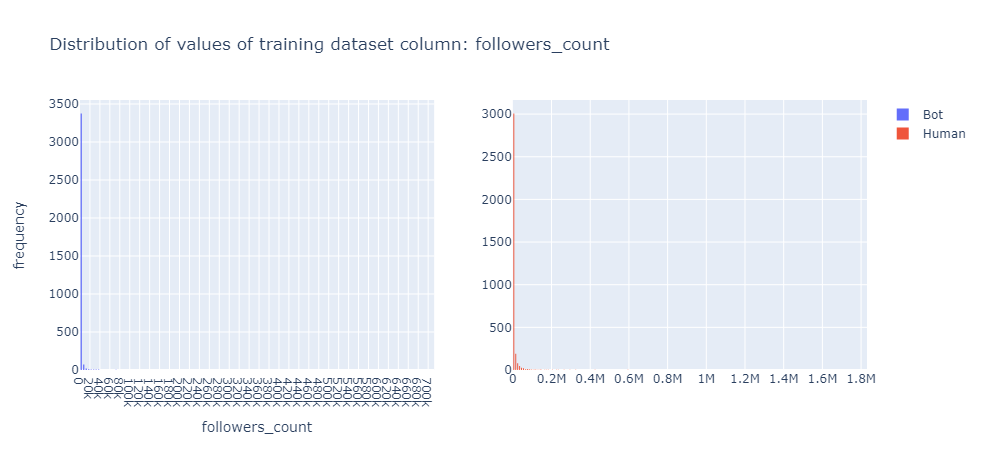

In [198]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='followers_count', dtick=20000, range=[0, max(train_data.loc[train_data['label']==1,'followers_count'])+10000]),
    xaxis2=dict(showgrid=True, dtick=200000, range=[0, max(train_data.loc[train_data['label']==0,'followers_count'])+100000]),
    yaxis=dict(showgrid=True))

fig.show()

#### followers_count - outliers

##### K-means (mnonot useful)

Number of outliers:  459


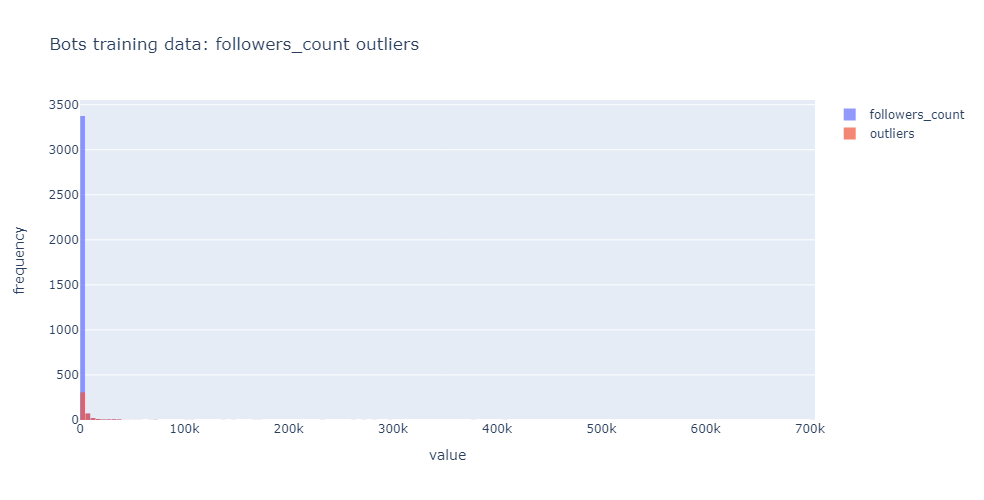

<Figure size 1500x700 with 0 Axes>

In [199]:
followers_count_bots_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==1], 'followers_count', title = "Bots training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

Number of outliers:  1088


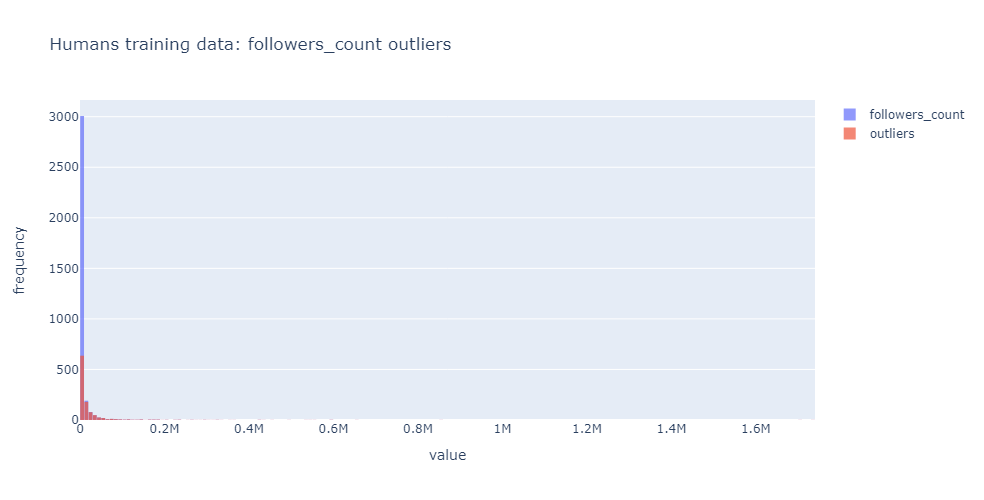

<Figure size 1500x700 with 0 Axes>

In [200]:
followers_count_humans_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==0], 'followers_count', title = "Humans training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

In [201]:
# q_hi_bots = train_data.loc[train_data['label']==1]['followers_count'].quantile(0.99, interpolation='nearest')
# q_hi_humans = train_data.loc[train_data['label']==0]['followers_count'].quantile(0.99, interpolation='nearest')

# df_filtered_bots = train_data.loc[train_data['label']==1][(train_data.loc[train_data['label']==1]['followers_count'] < q_hi_bots)]
# df_filtered_humans = train_data.loc[train_data['label']==0][(train_data.loc[train_data['label']==0]['followers_count'] < q_hi_humans)]

In [202]:
len(train_data[(train_data['label']==1)])

3527

In [203]:
len(train_data[(train_data['label']==0)])

3473

In [204]:
from scipy.stats import expon

# Fit an exponential distribution to data
loc_b, scale_b = expon.fit(train_data.loc[train_data['label']==1]['followers_count'])
loc_h, scale_h = expon.fit(train_data.loc[train_data['label']==0]['followers_count'])

# Calculate the 99th percentile using the percent-point function (inverse CDF)
percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
df_reduced_outliers_followers_count = train_data[((train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)) | ((train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans))]
df_filtered_bots = train_data[(train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)]
df_filtered_humans = train_data[(train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans)]

In [205]:
def df_99_percentile(df, column_name):
    # Fit an exponential distribution to data
    loc_b, scale_b = expon.fit(df.loc[df['label']==1][column_name])
    loc_h, scale_h = expon.fit(df.loc[df['label']==0][column_name])

    # Calculate the 99th percentile using the percent-point function (inverse CDF)
    percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
    percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
    return df[((df['label']==1) & (df[column_name] < percentile_99_bots)) | ((df['label']==0) & (df[column_name] < percentile_99_humans))]

In [206]:
len(df_filtered_bots)

3443

In [207]:
len(df_filtered_humans)

3343

In [208]:
len(df_reduced_outliers_followers_count) 

6786

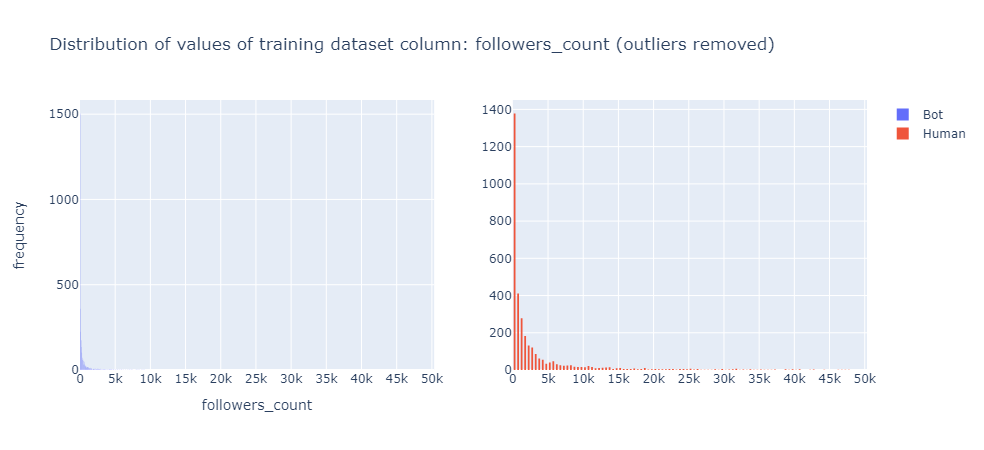

In [209]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count (outliers removed)',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=5000, range=[0, max(df_reduced_outliers_followers_count['followers_count'])+2500]),
    xaxis2=dict(showgrid=True, dtick=5000, range=[0, max(df_reduced_outliers_followers_count['followers_count'])+2500]),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count

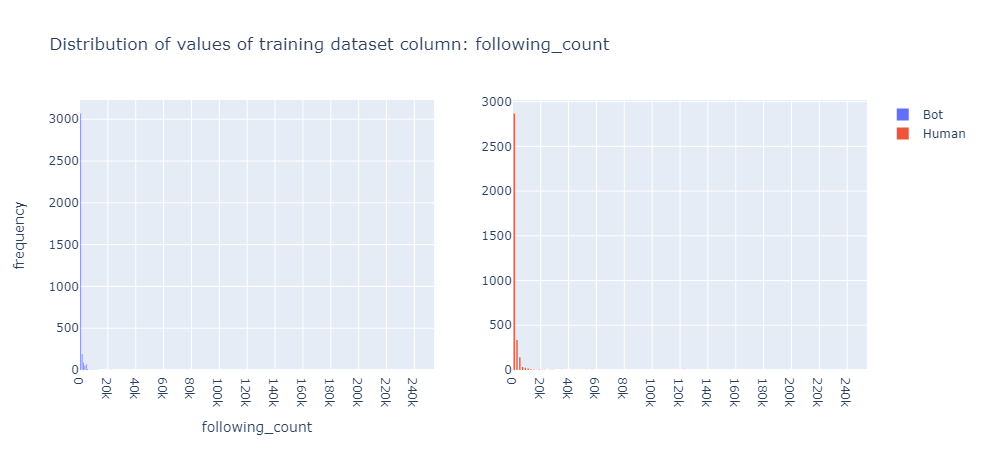

In [210]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=20000, range=[0, max(train_data['following_count'])+10000]),
    xaxis2=dict(showgrid=True, dtick=20000, range=[0, max(train_data['following_count'])+10000]),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count - outliers

In [211]:
df_reduced_outliers_following_count = df_99_percentile(df=train_data, column_name='following_count')

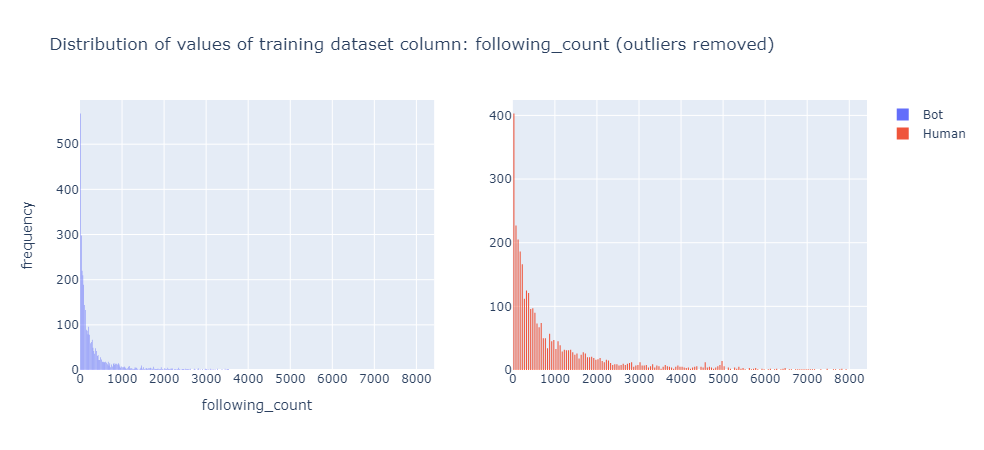

In [212]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count (outliers removed)',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000, range=[0, max(df_reduced_outliers_following_count['following_count'])+500]),
    xaxis2=dict(showgrid=True, dtick=1000, range=[0, max(df_reduced_outliers_following_count['following_count'])+500]),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count

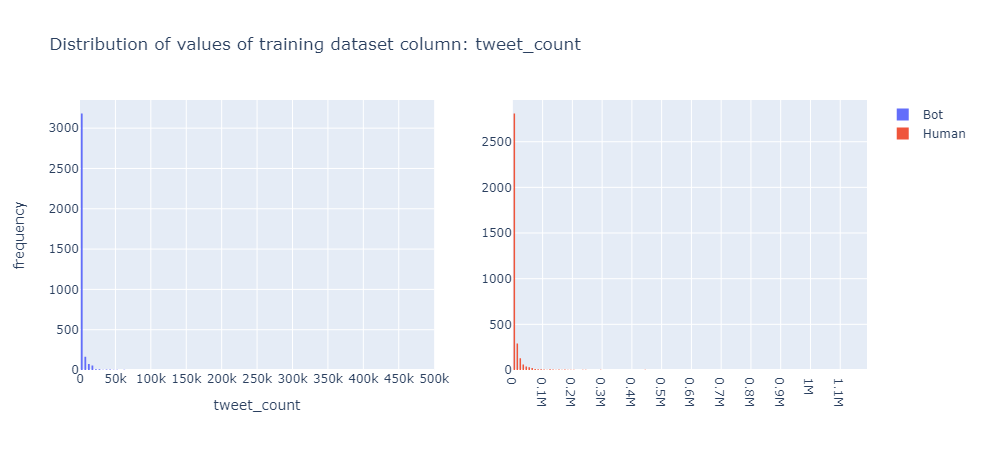

In [213]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=50000),
    xaxis2=dict(showgrid=True, dtick=100000),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count - outliers

In [214]:
df_reduced_outliers_tweet_count = df_99_percentile(df=train_data, column_name='tweet_count')

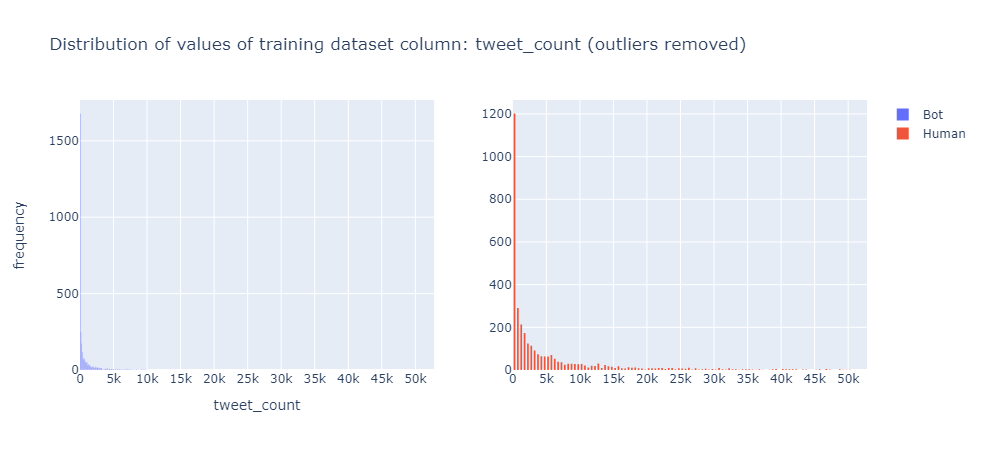

In [215]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count (outliers removed)',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=5000, range=[0, max(df_reduced_outliers_tweet_count['tweet_count'])+2500]),
    xaxis2=dict(showgrid=True, dtick=5000, range=[0, max(df_reduced_outliers_tweet_count['tweet_count'])+2500]),
    yaxis=dict(showgrid=True))

fig.show()

### descr_len

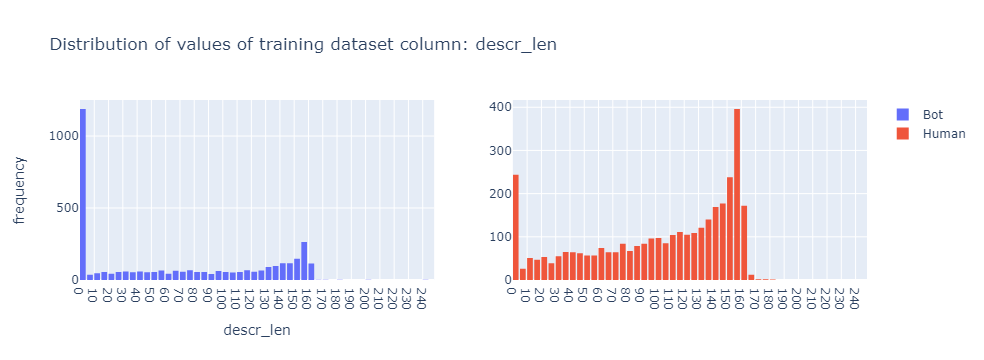

In [216]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10, range=[0, max(train_data['descr_len'])+5]),
    xaxis2=dict(showgrid=True, dtick=10, range=[0, max(train_data['descr_len'])+5]),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_len - outliers

In [217]:
q_hi_bots1 = train_data.loc[train_data['label']==1]['descr_len'].quantile(0.99, interpolation='nearest')
q_hi_humans1 = train_data.loc[train_data['label']==0]['descr_len'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_descr_len =  train_data[((train_data['label']==1) & (train_data['descr_len'] < q_hi_bots1)) | ((train_data['label']==0) & (train_data['descr_len'] < q_hi_humans1))]

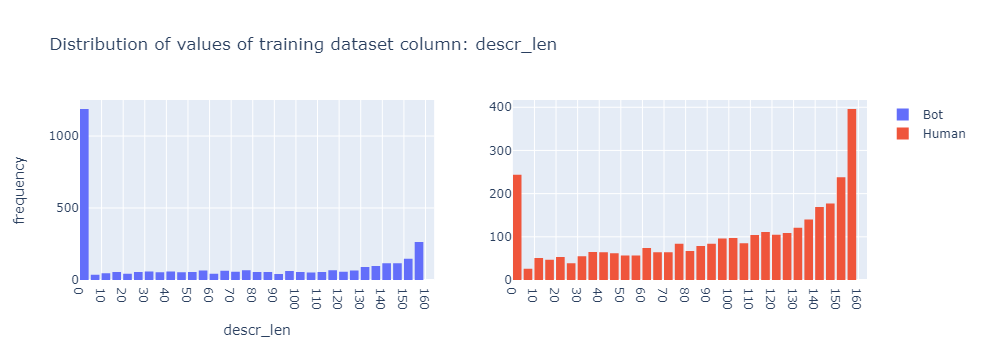

In [218]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10, range=[0, max(df_reduced_outliers_descr_len['descr_len'])+5]),
    xaxis2=dict(showgrid=True, dtick=10, range=[0, max(df_reduced_outliers_descr_len['descr_len'])+5]),
    yaxis=dict(showgrid=True))

fig.show()

### account_age

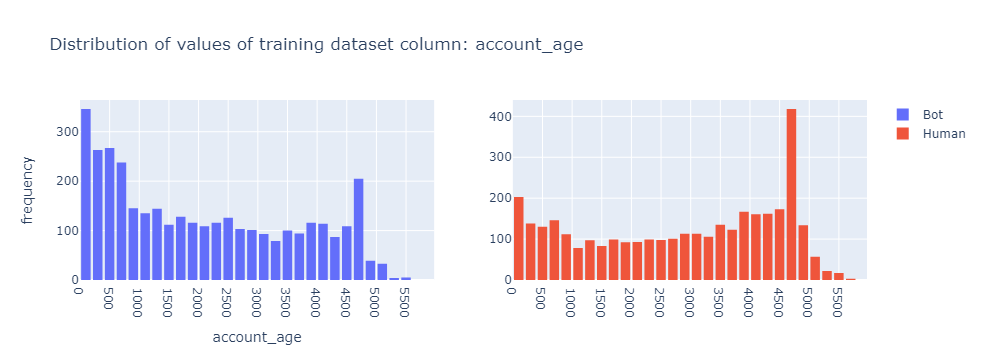

In [219]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500, range=[0, max(train_data['account_age'])+250]),
    xaxis2=dict(showgrid=True, dtick=500, range=[0, max(train_data['account_age'])+250]),
    yaxis=dict(showgrid=True))

fig.show()

#### account_age - outliers

In [220]:
q_hi_bots2 = train_data.loc[train_data['label']==1]['account_age'].quantile(0.99, interpolation='nearest')
q_hi_humans2 = train_data.loc[train_data['label']==0]['account_age'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_account_age =  train_data[((train_data['label']==1) & (train_data['account_age'] < q_hi_bots2)) | ((train_data['label']==0) & (train_data['account_age'] < q_hi_humans2))]

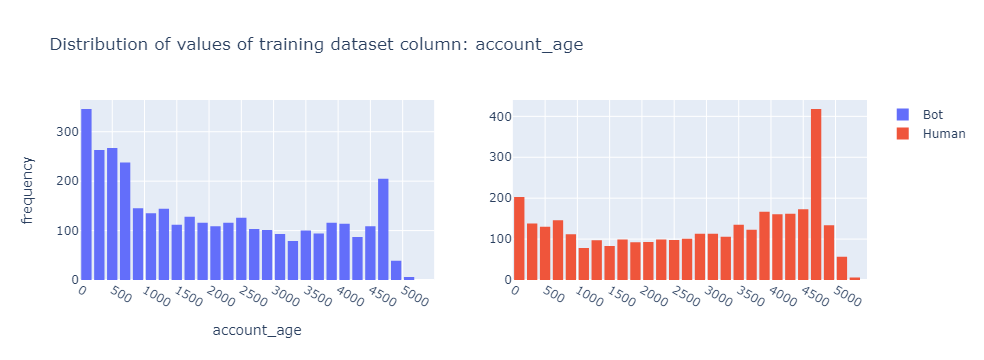

In [221]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_account_age.loc[df_reduced_outliers_account_age['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_account_age.loc[df_reduced_outliers_account_age['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500, range=[0, max(df_reduced_outliers_account_age['account_age'])+250]),
    xaxis2=dict(showgrid=True, dtick=500, range=[0, max(df_reduced_outliers_account_age['account_age'])+250]),
    yaxis=dict(showgrid=True))

fig.show()

### country_numeric

In [222]:
def map_contries_to_str(numeric_encoded_country_list):
    mapped_countries = []
    for i,row in enumerate(numeric_encoded_country_list):
        numeric_value = int(row)
        res = dict((v,k) for k,v in country_dict.items())
        mapped_countries.append(res[numeric_value])
    return mapped_countries

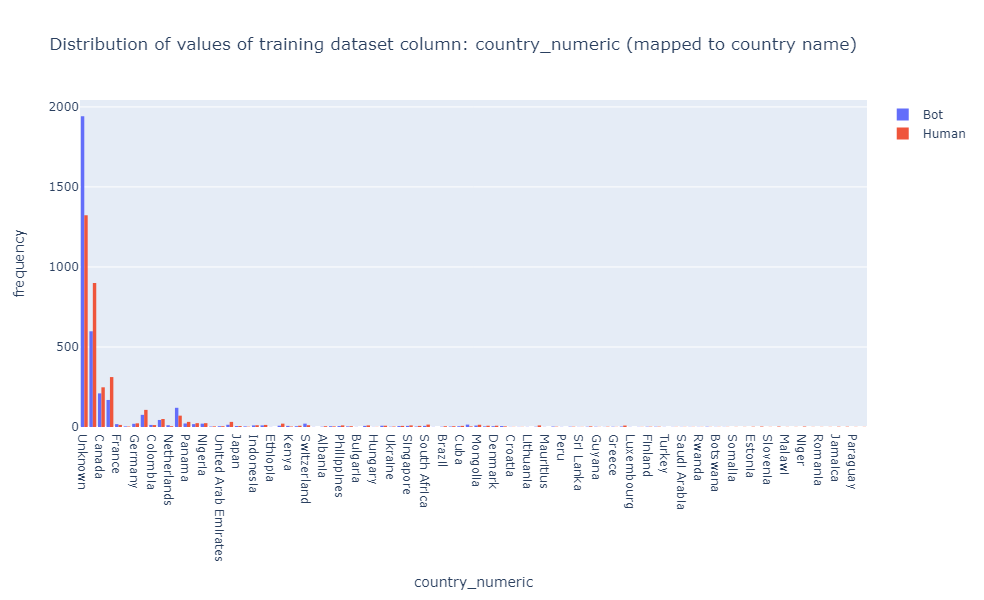

In [223]:
fig = go.Figure()
# fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=map_contries_to_str(train_data.loc[train_data['label']==1,'country_numeric']),
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
# row=1, col=1
)
fig.add_trace(go.Histogram(
    x=map_contries_to_str(train_data.loc[train_data['label']==0,'country_numeric']),
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
# row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: country_numeric (mapped to country name)',
    xaxis_title_text='country_numeric', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1200,
    height=600,
    legend={"title":""},
    # xaxis=dict(showgrid=True, dtick=10),
    # xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

#### country_numeric - outliers

In [224]:
df_reduced_outliers_country_numeric = df_99_percentile(df=train_data, column_name='country_numeric')

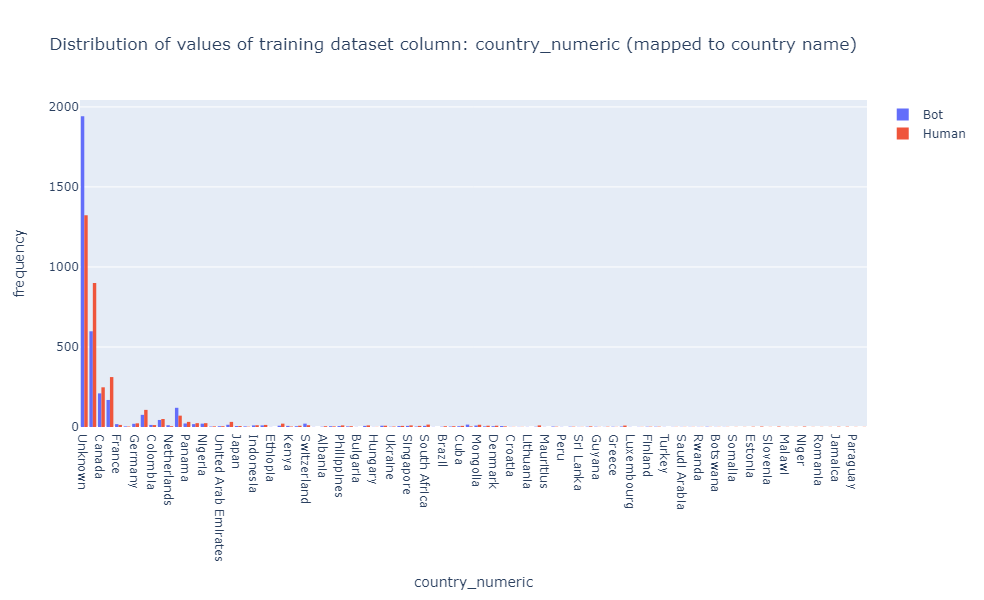

In [225]:
fig = go.Figure()
# fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=map_contries_to_str(df_reduced_outliers_country_numeric.loc[df_reduced_outliers_country_numeric['label']==1,'country_numeric']),
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
# row=1, col=1
)
fig.add_trace(go.Histogram(
    x=map_contries_to_str(df_reduced_outliers_country_numeric.loc[df_reduced_outliers_country_numeric['label']==0,'country_numeric']),
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
# row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: country_numeric (mapped to country name)',
    xaxis_title_text='country_numeric', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1200,
    height=600,
    legend={"title":""},
    # xaxis=dict(showgrid=True, dtick=10),
    # xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

### Create merged dataframe from reduced by columns outliers dataframes

In [226]:
# train_data_wo_outliers = df_reduced_outliers_followers_count.merge(df_reduced_outliers_following_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_tweet_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_listed_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_hashtags, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# # train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_cashtags, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_mentions, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_urls, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_url_no_urls, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_len, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_account_age, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_country_numeric, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [227]:
train_data_wo_outliers = df_reduced_outliers_followers_count.merge(df_reduced_outliers_following_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

rest_of_df = [df_reduced_outliers_tweet_count, 
              df_reduced_outliers_descr_len,
              df_reduced_outliers_account_age,
              df_reduced_outliers_country_numeric]

for df in rest_of_df:
    if (len(df.loc[df['label']==1]) > 0 and len(df.loc[df['label']==0]) > 0):
        train_data_wo_outliers = train_data_wo_outliers.merge(df, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [228]:
len(train_data_wo_outliers)

6034

In [229]:
train_data_wo_outliers

label            id  followers_count  tweet_count  following_count  \
0       0.0  1.214019e+18            554.0        186.0            562.0   
1       0.0  1.099278e+08           2764.0       5129.0           1497.0   
2       1.0  1.362188e+18              0.0          1.0             54.0   
3       0.0  1.105811e+18            306.0       4613.0            163.0   
4       1.0  4.814260e+08             89.0          1.0            200.0   
...     ...           ...              ...          ...              ...   
6029    1.0  5.724116e+08             52.0          3.0            481.0   
6030    0.0  4.348814e+09             37.0         30.0            304.0   
6031    1.0  3.684963e+08             72.0         15.0             81.0   
6032    1.0  1.412609e+18             19.0        693.0            134.0   
6033    1.0  1.438696e+18              2.0        450.0              0.0   

      account_age  descr_len  country_numeric  
0           800.0      147.0             41.0  
1          4428.0      151.0              1.0  
2           392.0        0.0              1.0  
3          1099.0      144.0            236.0  
4          3695.0      129.0            236.0  
...           ...        ...              ...  
6029       3601.0        0.0              1.0  
6030       2296.0        0.0              1.0  
6031       3845.0      152.0            236.0  
6032        252.0       29.0              1.0  
6033        180.0       34.0            236.0  

[6034 rows x 8 columns]

#### Drop 'id' column

In [230]:
train_data = train_data.drop(['id'], axis=1)
val_data = val_data.drop(['id'], axis=1)
test_data = test_data.drop(['id'], axis=1)

train_data_wo_outliers = train_data_wo_outliers.drop(['id'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['id'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['id'], axis=1)

### Filter to have the same number of records for each class - part II

In [231]:
train_data = filter_df_for_balanced_classes(train_data, bot_label_value=1, human_label_value=0)
val_data = filter_df_for_balanced_classes(val_data, bot_label_value=1, human_label_value=0)
test_data = filter_df_for_balanced_classes(test_data, bot_label_value=1, human_label_value=0)

Number of bots:  3473
Number of human users:  3473
Number of bots:  743
Number of human users:  743
Number of bots:  730
Number of human users:  730


In [232]:
train_data_wo_outliers = filter_df_for_balanced_classes(train_data_wo_outliers, bot_label_value=1, human_label_value=0)
val_data_wo_outliers = filter_df_for_balanced_classes(val_data_wo_outliers, bot_label_value=1, human_label_value=0)
test_data_wo_outliers = filter_df_for_balanced_classes(test_data_wo_outliers, bot_label_value=1, human_label_value=0)

Number of bots:  2966
Number of human users:  2966
Number of bots:  743
Number of human users:  743
Number of bots:  730
Number of human users:  730


### Normalize data by column range of training set

In [233]:
# train_dataframe = pd.DataFrame(train_data).copy()
# val_dataframe = pd.DataFrame(val_data).copy()
# test_dataframe = pd.DataFrame(test_data).copy()

# train_dataframe_wo_outliers = pd.DataFrame(train_data_wo_outliers).copy()
# val_dataframe_wo_outliers = pd.DataFrame(val_data_wo_outliers).copy()
# test_dataframe_wo_outliers = pd.DataFrame(test_data_wo_outliers).copy()

In [234]:
columns_to_normalize = ['followers_count', 'tweet_count', 'following_count', 'account_age', 'descr_len']

In [235]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(train_data[columns_to_normalize])

train_data[columns_to_normalize] = min_max_scaler.transform(train_data[columns_to_normalize])
val_data[columns_to_normalize]   = min_max_scaler.transform(val_data[columns_to_normalize])
test_data[columns_to_normalize]  = min_max_scaler.transform(test_data[columns_to_normalize])

In [236]:
min_max_scaler_outliers = MinMaxScaler()
min_max_scaler_outliers.fit(train_data_wo_outliers[columns_to_normalize])

train_data_wo_outliers[columns_to_normalize] = min_max_scaler_outliers.transform(train_data_wo_outliers[columns_to_normalize])
val_data_wo_outliers[columns_to_normalize]   = min_max_scaler_outliers.transform(val_data_wo_outliers[columns_to_normalize])
test_data_wo_outliers[columns_to_normalize]  = min_max_scaler_outliers.transform(test_data_wo_outliers[columns_to_normalize])

#### Column country_numeric normalize based on all possible values - dictionary country_dict

In [237]:
def custom_min_max_norm(df, col_name, min_val, max_val):
    df[col_name] = ((df[col_name] - min_val) / (max_val - min_val))
    return df

In [238]:
min(train_data['country_numeric'])

1.0

In [239]:
max(train_data['country_numeric'])

250.0

In [240]:
country_numeric_col = 'country_numeric'
min_val = min(country_dict.values())
max_val = max(country_dict.values())

train_data = custom_min_max_norm(train_data, country_numeric_col, min_val, max_val)
val_data = custom_min_max_norm(val_data, country_numeric_col, min_val, max_val)
test_data = custom_min_max_norm(test_data, country_numeric_col, min_val, max_val)

train_data_wo_outliers = custom_min_max_norm(train_data_wo_outliers, country_numeric_col, min_val, max_val)
val_data_wo_outliers = custom_min_max_norm(val_data_wo_outliers, country_numeric_col, min_val, max_val)
test_data_wo_outliers = custom_min_max_norm(test_data_wo_outliers, country_numeric_col, min_val, max_val)

In [241]:
train_data

label  followers_count   tweet_count  following_count  account_age  \
6625    0.0         0.000320  1.570096e-04         0.002301     0.136443   
2489    0.0         0.001597  4.329582e-03         0.006130     0.772711   
9919    0.0         0.001224  2.175343e-03         0.020480     0.515433   
6964    1.0         0.000000  8.441376e-07         0.000221     0.064890   
3467    0.0         0.000177  3.894007e-03         0.000667     0.188881   
...     ...              ...           ...              ...          ...   
3325    0.0         0.000305  1.915348e-03         0.006495     0.585058   
1881    0.0         0.000627  4.270492e-03         0.016188     0.712732   
4861    0.0         0.000007  3.376550e-06         0.000385     0.447212   
1175    0.0         0.000021  2.532413e-05         0.001245     0.398807   
8447    0.0         0.103158  6.812190e-04         0.001740     0.282532   

      descr_len  country_numeric  
6625   0.604938            0.164  
2489   0.621399            0.004  
9919   0.658436            0.660  
6964   0.000000            0.004  
3467   0.592593            0.944  
...         ...              ...  
3325   0.658436            0.004  
1881   0.609053            0.004  
4861   0.197531            0.944  
1175   0.000000            0.004  
8447   0.572016            0.944  

[6946 rows x 7 columns]

In [242]:
min(train_data['country_numeric'])

0.004

In [243]:
max(train_data['country_numeric'])

1.0

## Correlation

#### First drop columns in dataframes where there are same value in whole columns in trin dataset

In [244]:
same_data_columns = list(train_data.columns[train_data.apply(lambda x: x.nunique()) == 1])
same_data_columns

[]

In [245]:
train_data = train_data.drop(same_data_columns, axis=1)

val_data = val_data.drop(same_data_columns, axis=1)
test_data = test_data.drop(same_data_columns, axis=1)

In [246]:
sns.set(font_scale=3)

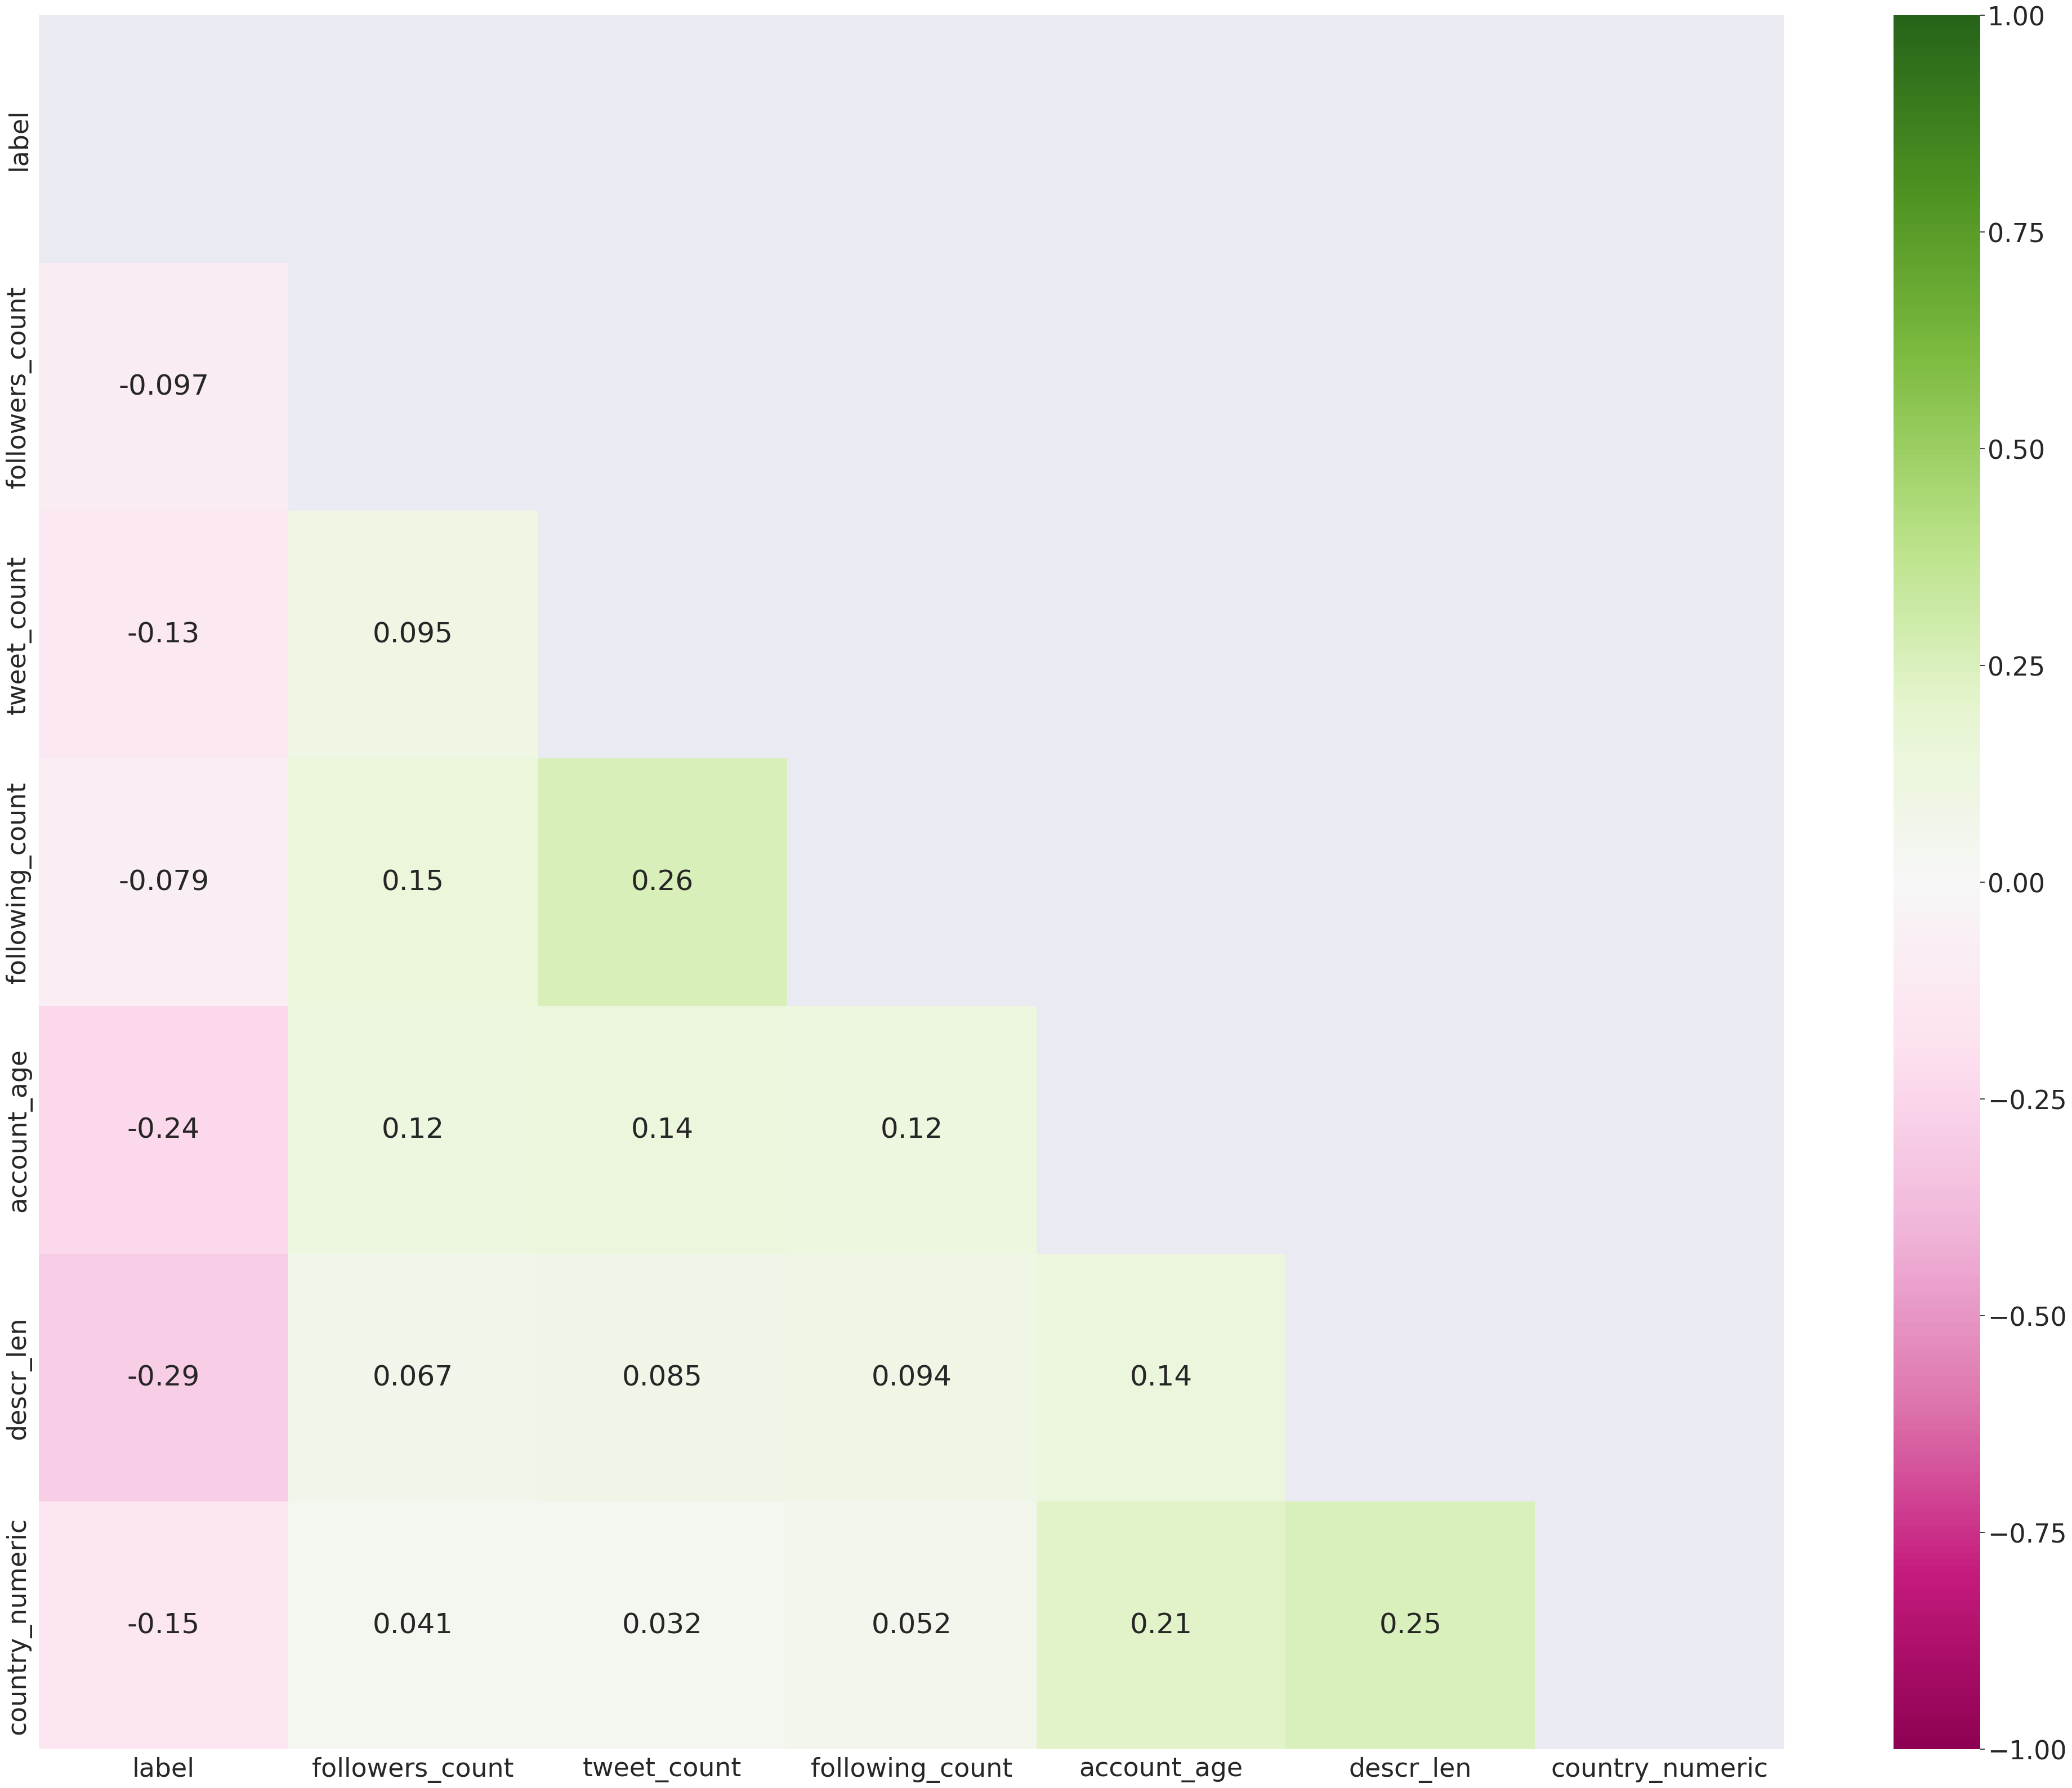

In [247]:
corr_threshold = 0.52
corr = train_data.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_data:
   for col in train_data:
     if abs(lower_tri[column][col]) > corr_threshold:
         high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [248]:
sns.set(font_scale=1)

In [249]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

Number of columns containing high correlation: 0


[]

In [250]:
train_data

label  followers_count   tweet_count  following_count  account_age  \
6625    0.0         0.000320  1.570096e-04         0.002301     0.136443   
2489    0.0         0.001597  4.329582e-03         0.006130     0.772711   
9919    0.0         0.001224  2.175343e-03         0.020480     0.515433   
6964    1.0         0.000000  8.441376e-07         0.000221     0.064890   
3467    0.0         0.000177  3.894007e-03         0.000667     0.188881   
...     ...              ...           ...              ...          ...   
3325    0.0         0.000305  1.915348e-03         0.006495     0.585058   
1881    0.0         0.000627  4.270492e-03         0.016188     0.712732   
4861    0.0         0.000007  3.376550e-06         0.000385     0.447212   
1175    0.0         0.000021  2.532413e-05         0.001245     0.398807   
8447    0.0         0.103158  6.812190e-04         0.001740     0.282532   

      descr_len  country_numeric  
6625   0.604938            0.164  
2489   0.621399            0.004  
9919   0.658436            0.660  
6964   0.000000            0.004  
3467   0.592593            0.944  
...         ...              ...  
3325   0.658436            0.004  
1881   0.609053            0.004  
4861   0.197531            0.944  
1175   0.000000            0.004  
8447   0.572016            0.944  

[6946 rows x 7 columns]

In [251]:
# train_data = train_data.drop(['listed_count'], axis=1)
# val_data = val_data.drop(['listed_count'], axis=1)
# test_data = test_data.drop(['listed_count'], axis=1)

### Correlation of data reduced by outliers

#### First drop columns in filter (without outliers) dataframe where now have same value in whole column

In [252]:
same_data_columns = list(train_data_wo_outliers.columns[train_data_wo_outliers.apply(lambda x: x.nunique()) == 1])
same_data_columns

[]

In [253]:
train_data_wo_outliers = train_data_wo_outliers.drop(same_data_columns, axis=1)

val_data_wo_outliers = val_data_wo_outliers.drop(same_data_columns, axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(same_data_columns, axis=1)

#### Correlation

In [254]:
sns.set(font_scale=3)

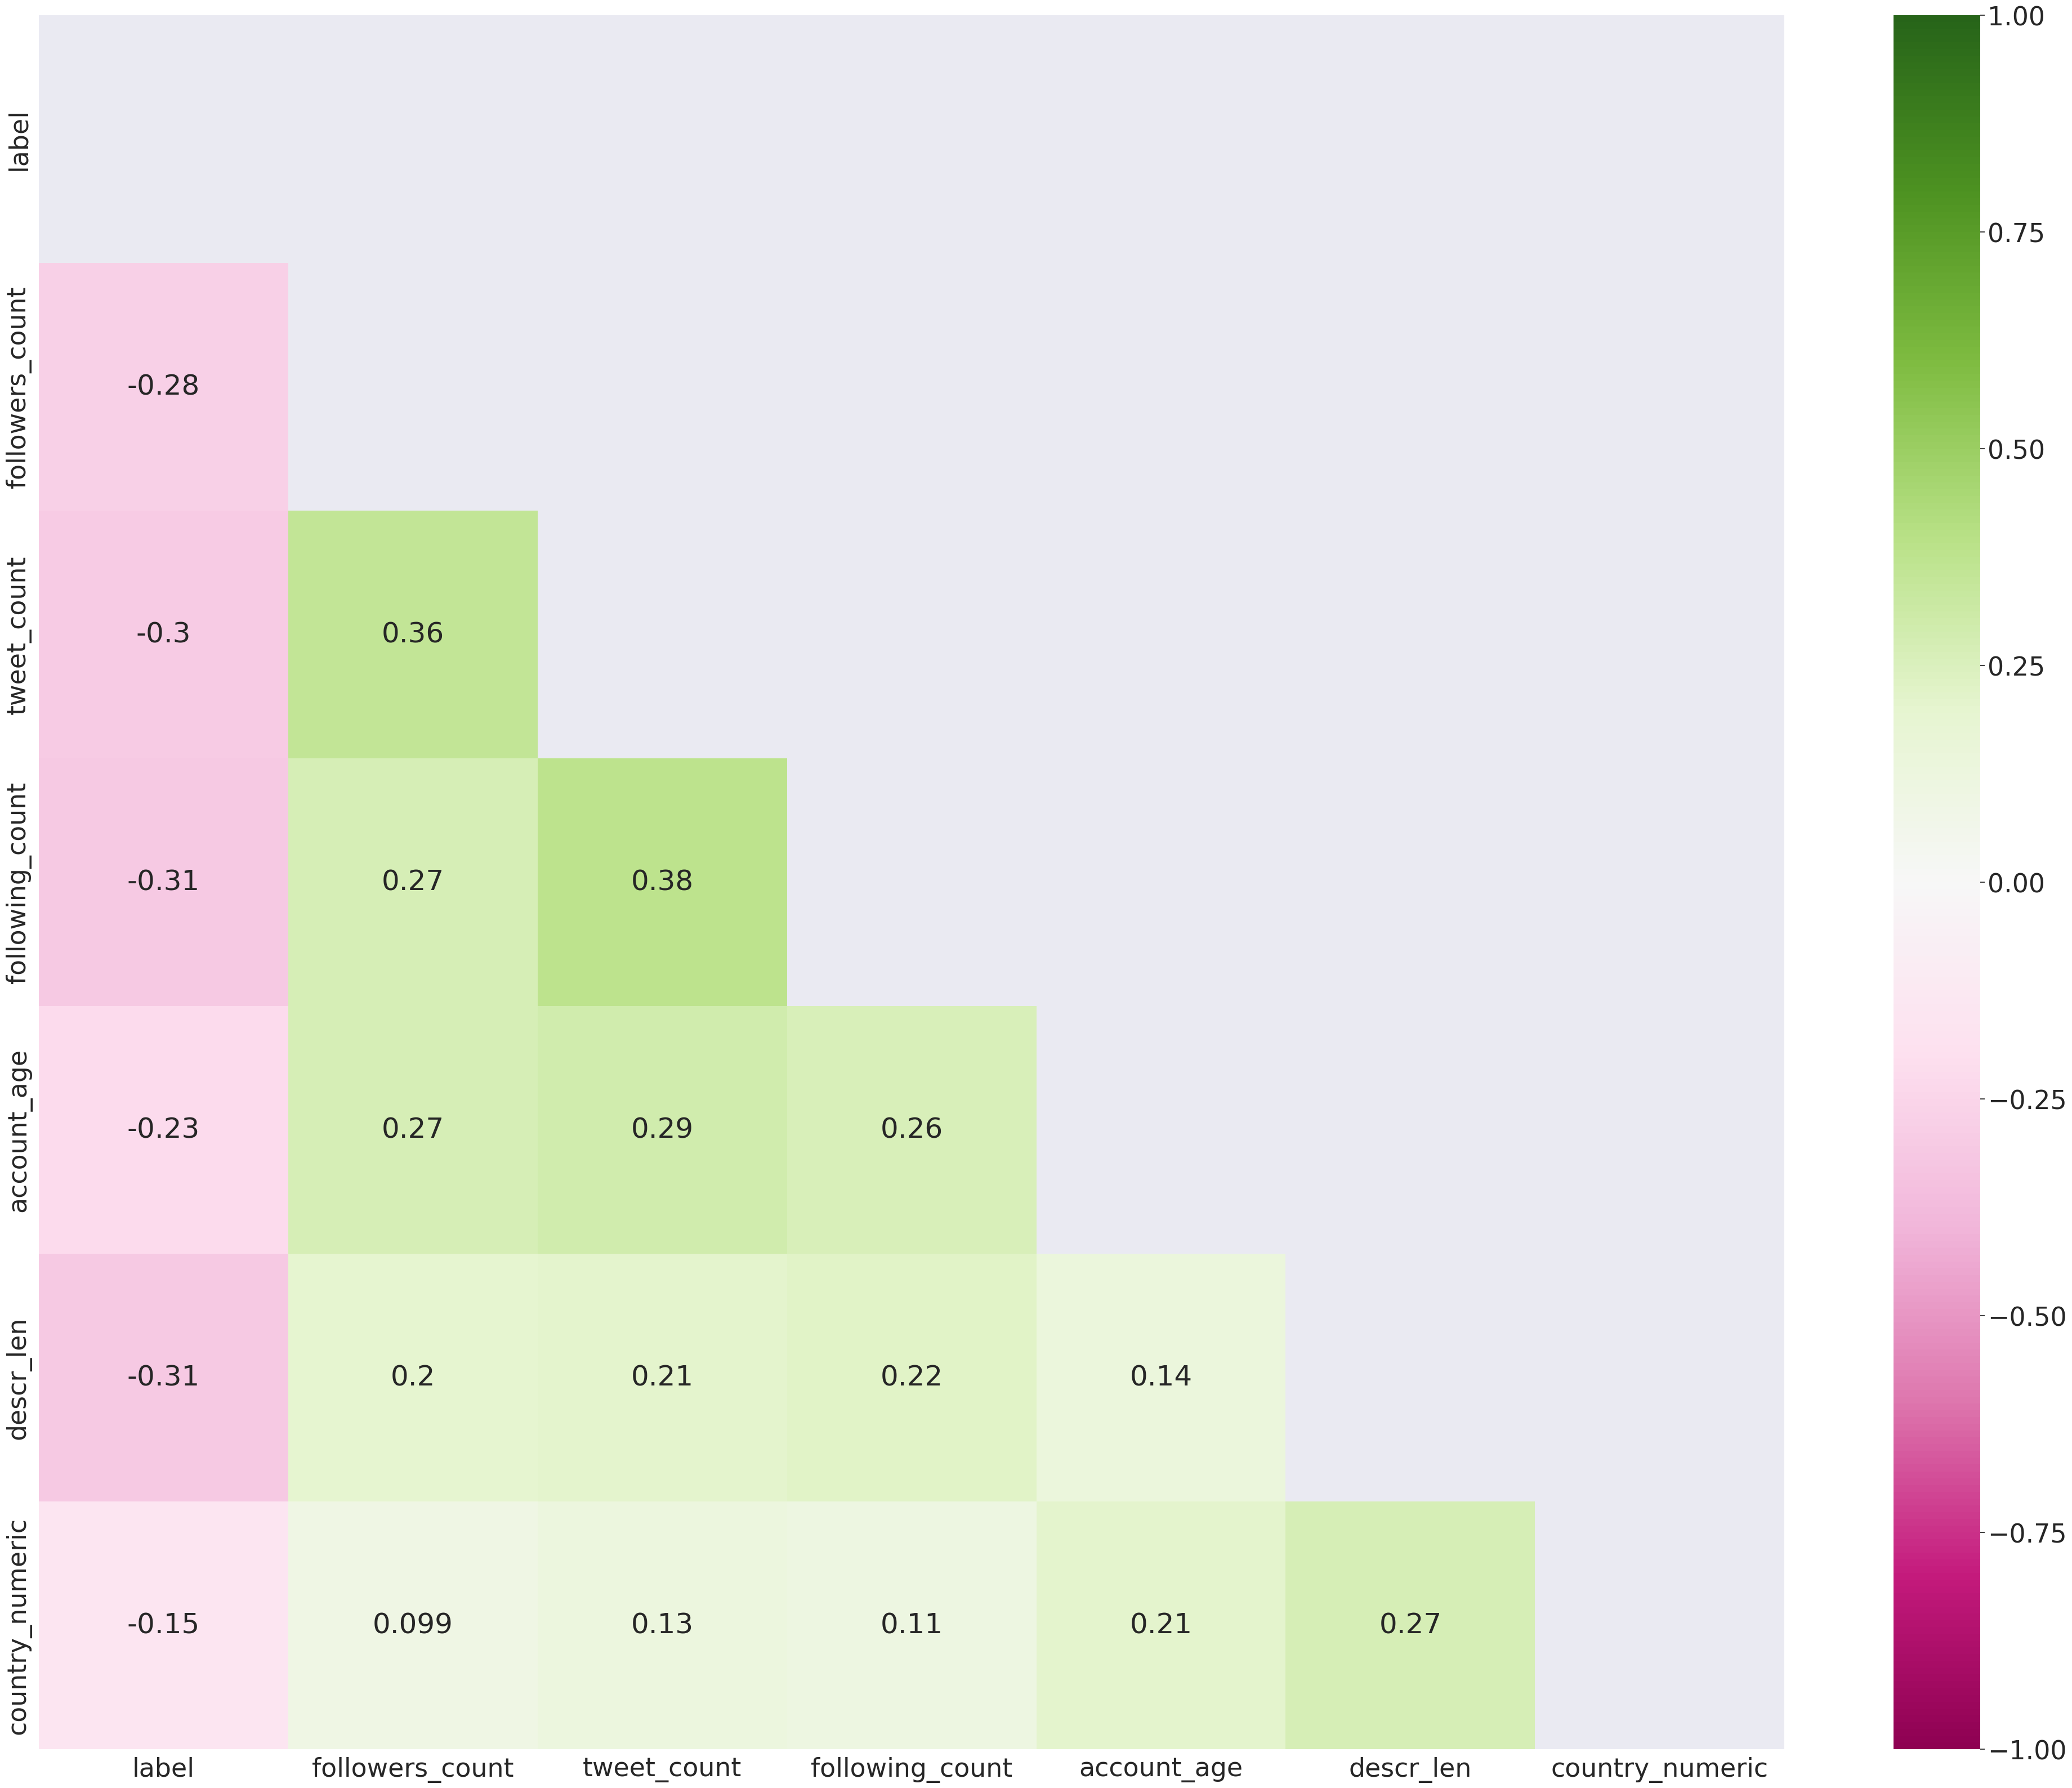

In [255]:
corr_threshold2 = 0.52
corr2 = train_data_wo_outliers.corr()
lower_tri2 = corr2.where(np.tril(np.ones(corr2.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri2, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr2 = []
for column in train_data_wo_outliers:
   for col in train_data_wo_outliers:
     if abs(lower_tri2[column][col]) > corr_threshold2:
         high_corr2.append((column, col, lower_tri2[column][col]))
high_corr2 = sorted(high_corr2, key=lambda x: x[2], reverse=True)

#### Drop column with higher correlation

In [256]:
f = plt.figure(figsize=(50, 40))
sns.set(font_scale=1)

<Figure size 5000x4000 with 0 Axes>

In [257]:
high_corr2

[]

In [258]:
# train_data_wo_outliers = train_data_wo_outliers.drop(['listed_count', 'has_description', 'has_location', 'url_no_urls'], axis=1)
# val_data_wo_outliers = val_data_wo_outliers.drop(['listed_count', 'has_description', 'has_location', 'url_no_urls'], axis=1)
# test_data_wo_outliers = test_data_wo_outliers.drop(['listed_count', 'has_description', 'has_location', 'url_no_urls'], axis=1)

#### Split data for input and output

In [259]:
train_X = train_data.drop(['label'], axis=1)
train_Y = pd.concat([train_data['label']], axis=1)
val_X = val_data.drop(['label'], axis=1)
val_Y = pd.concat([val_data['label']], axis=1)
test_X = test_data.drop(['label'], axis=1)
test_Y = pd.concat([test_data['label']], axis=1)


train_data_wo_outliers_X = train_data_wo_outliers.drop(['label'], axis=1)
train_data_wo_outliers_Y = pd.concat([train_data_wo_outliers['label']], axis=1)
val_data_wo_outliers_X = val_data_wo_outliers.drop(['label'], axis=1)
val_data_wo_outliers_Y = pd.concat([val_data_wo_outliers['label']], axis=1)
test_data_wo_outliers_X = test_data_wo_outliers.drop(['label'], axis=1)
test_data_wo_outliers_Y = pd.concat([test_data_wo_outliers['label']], axis=1)

# DNN models

#### Function to load a saved neural network model

In [260]:
from keras.models import load_model

def load_model_from_file(filepath):
  model = load_model(filepath)
  return model

#### Summary of metrics based on real and predicted data by the network

In [261]:
def get_model_metrics(test_Y, out_Y):
  accuracy = accuracy_score(test_Y, out_Y)
  print('Accuracy: {}'.format(accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(test_Y, out_Y, average=None)
  print('Precision: {}'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(test_Y, out_Y)
  print('Recall: {}'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_Y, out_Y)
  print('F1 score: %f' % f1)
  # ROC AUC
  auc = roc_auc_score(test_Y, out_Y)
  print('ROC AUC: %f' % auc)
  return (accuracy, precision, recall, f1, auc)

#### Creating a confusion matrix

In [262]:
def create_confusion_matrix(test_Y, out_Y):
    cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure()
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    sns.heatmap(
        cm,
        annot=labels,
        annot_kws={"size": 12},
        fmt='',
        cmap=plt.cm.Blues,
        cbar=False
    )
    ax.set_title("Confusion matrix", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    
    fig.show()

## Neural network models 

In [263]:
# EarlyStopping
def early_stop(metric='val_accuracy', mode = 'max', patience=50):
    return EarlyStopping(monitor='val_accuracy',
                           patience=patience,
                           restore_best_weights=True,
                           mode=mode)
# PlotLosses
def plot_losses():
    return PlotLossesCallback()

# ModelCheckpoint
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath = models_path + '/' + model_name + '.hdf5',
                            monitor = "val_accuracy",
                            save_best_only = True,
                            # save_weights_only = True,
                            verbose=1)

In [264]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses(),
                           early_stop(),
                           checkpoint_callback(model_name)])
    return model

## Model 1.

#### Create model

In [265]:
def create_model_1(shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
  model = Sequential()
  model.add(Input(shape=shape)),
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
  return model

### batch_size=10, epochs=300

#### Create and train model

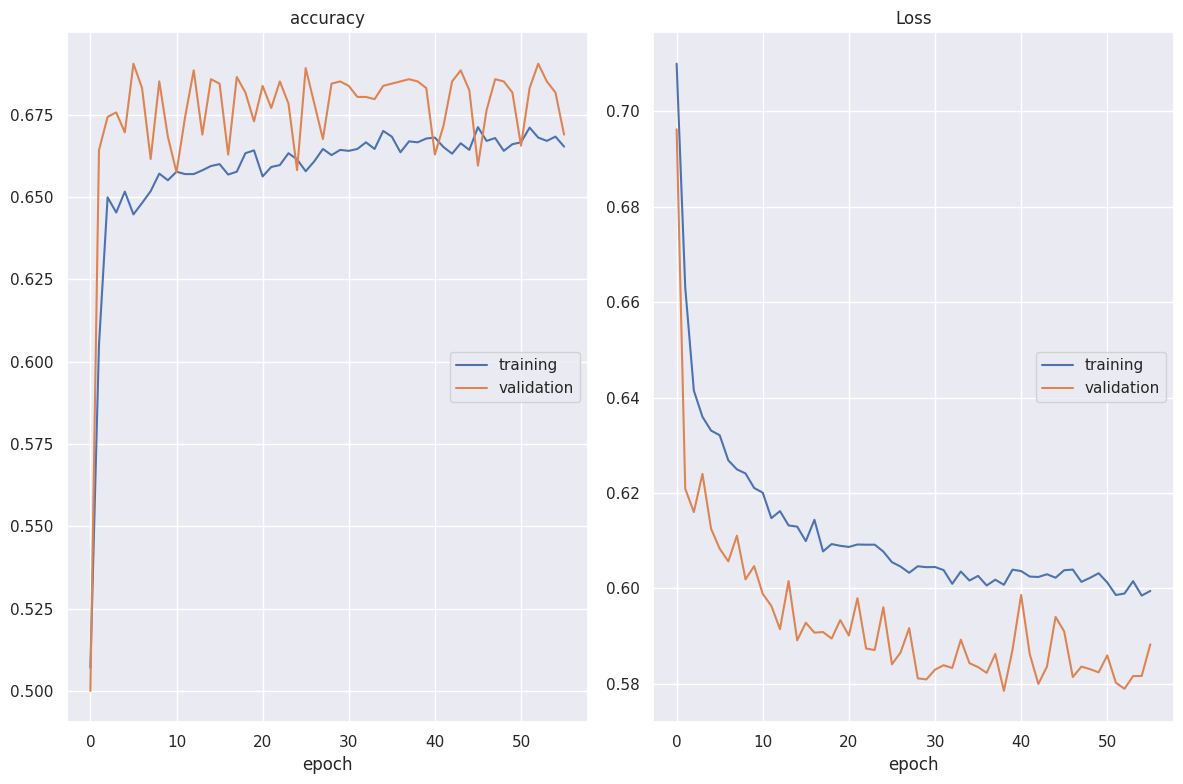

accuracy
	training         	 (min:    0.507, max:    0.671, cur:    0.665)
	validation       	 (min:    0.500, max:    0.690, cur:    0.669)
Loss
	training         	 (min:    0.598, max:    0.710, cur:    0.599)
	validation       	 (min:    0.579, max:    0.696, cur:    0.588)

Epoch 56: val_accuracy did not improve from 0.69044
695/695 [==============================] - 3s 4ms/step - loss: 0.5995 - accuracy: 0.6653 - val_loss: 0.5883 - val_accuracy: 0.6689


In [266]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v1_batch_size_10_only_import_feat_norm'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=10, epochs=300)

#### Prediction and results

Accuracy: 0.6678082191780822
Precision: [0.68875193 0.65104809]
Recall: 0.7232876712328767
F1 score: 0.685269
ROC AUC: 0.667808


(0.6678082191780822,
 array([0.68875193, 0.65104809]),
 0.7232876712328767,
 0.6852693056456848,
 0.6678082191780822)

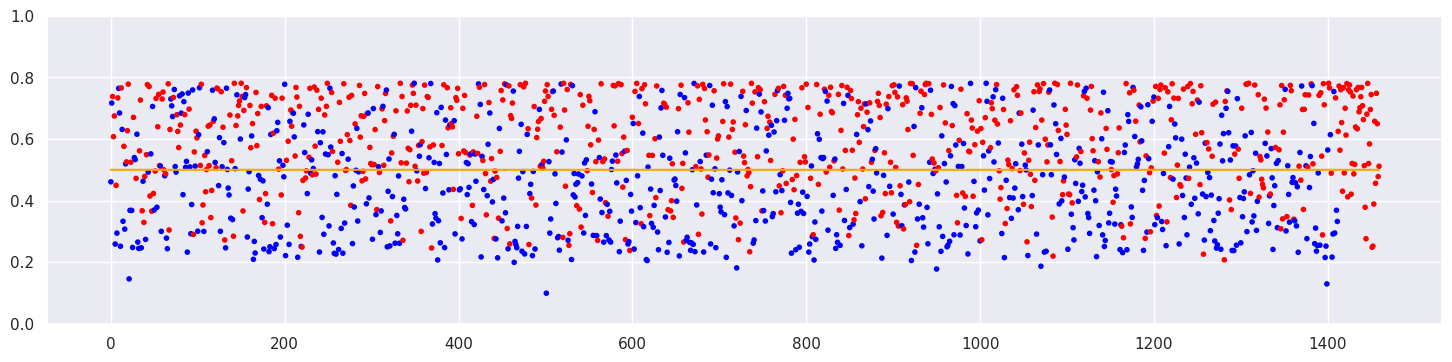

<Figure size 640x480 with 0 Axes>

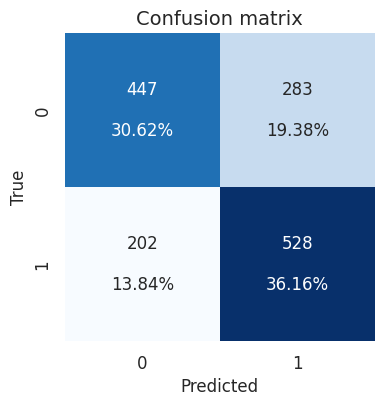

In [267]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=50, epochs=300

In [268]:
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
print(model1_v1.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_85 (Dense)            (None, 32)                224       
                                                                 
 dense_86 (Dense)            (None, 32)                1056      
                                                                 
 dropout_34 (Dropout)        (None, 32)                0         
                                                                 
 dense_87 (Dense)            (None, 64)                2112      
                                                                 
 dense_88 (Dense)            (None, 64)                4160      
                                                                 
 dropout_35 (Dropout)        (None, 64)                0         
                                                                 
 dense_89 (Dense)            (None, 1)               

### Train model

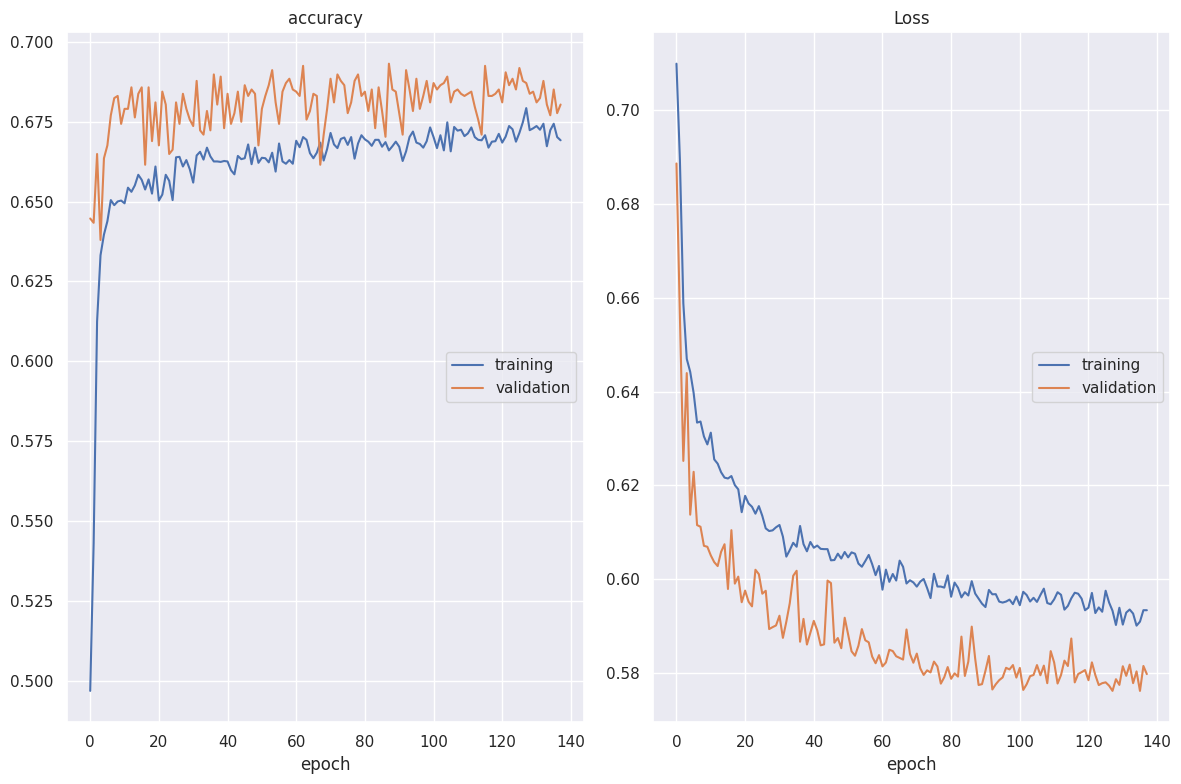

accuracy
	training         	 (min:    0.497, max:    0.679, cur:    0.669)
	validation       	 (min:    0.638, max:    0.693, cur:    0.680)
Loss
	training         	 (min:    0.590, max:    0.710, cur:    0.593)
	validation       	 (min:    0.576, max:    0.689, cur:    0.580)

Epoch 138: val_accuracy did not improve from 0.69314
139/139 [==============================] - 1s 8ms/step - loss: 0.5934 - accuracy: 0.6692 - val_loss: 0.5798 - val_accuracy: 0.6803


In [269]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v1_batch_size_50_only_import_feat_norm'
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=50, epochs=300)

In [270]:
# Load model
# model = load_model_from_file(models_path + '/model_name.hdf5')

#### Prediction

In [271]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

#### Results

(0.0, 1.0)

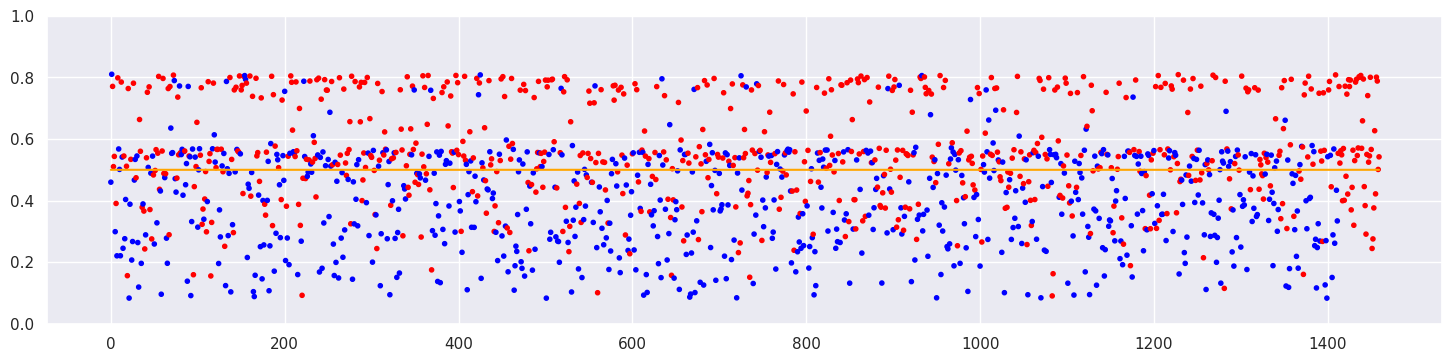

In [272]:
x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

#### Confusion matrix

Accuracy: 0.6726027397260274
Precision: [0.67027027 0.675     ]
Recall: 0.6657534246575343
F1 score: 0.670345
ROC AUC: 0.672603


(0.6726027397260274,
 array([0.67027027, 0.675     ]),
 0.6657534246575343,
 0.670344827586207,
 0.6726027397260274)

<Figure size 640x480 with 0 Axes>

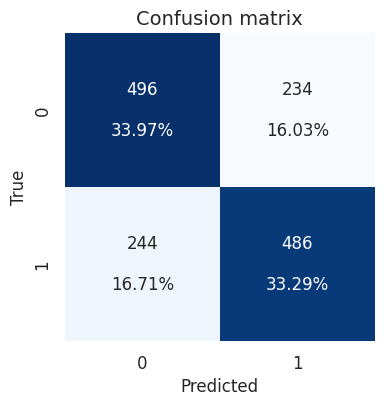

In [273]:
create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=100, epochs=300

#### Create and train model

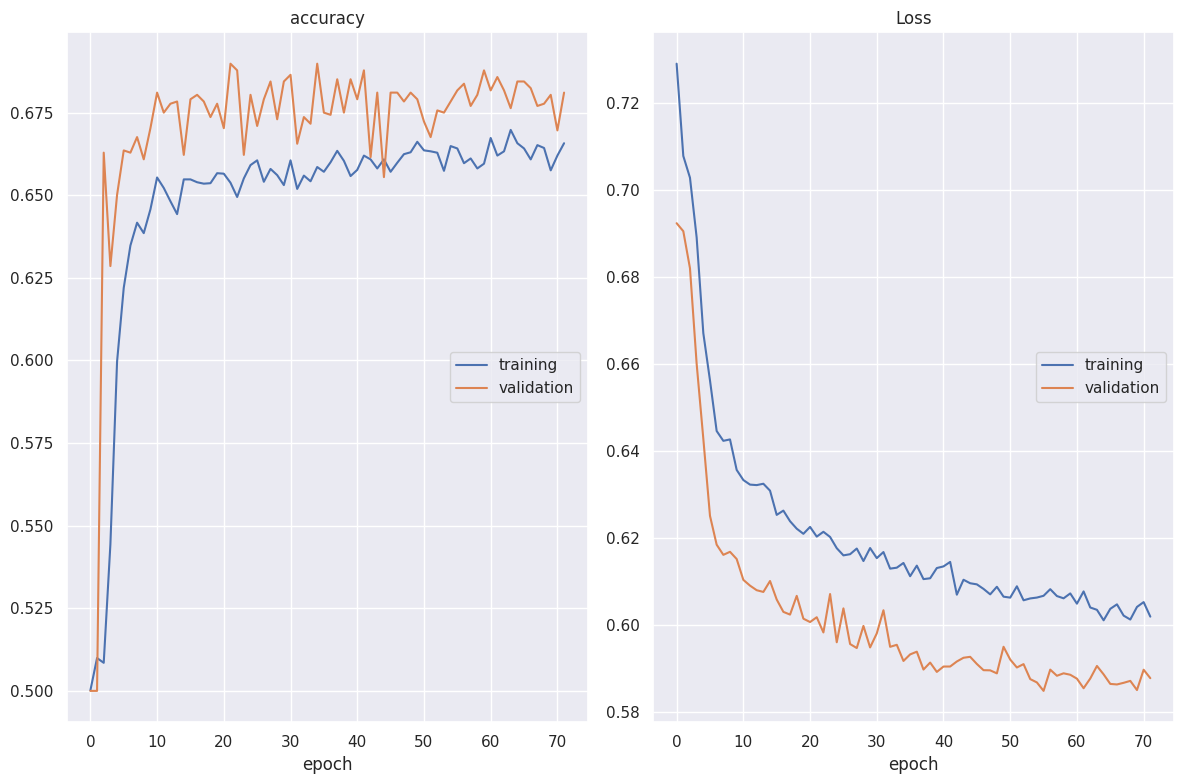

accuracy
	training         	 (min:    0.500, max:    0.670, cur:    0.666)
	validation       	 (min:    0.500, max:    0.690, cur:    0.681)
Loss
	training         	 (min:    0.601, max:    0.729, cur:    0.602)
	validation       	 (min:    0.585, max:    0.692, cur:    0.588)

Epoch 72: val_accuracy did not improve from 0.68977
70/70 [==============================] - 1s 13ms/step - loss: 0.6019 - accuracy: 0.6657 - val_loss: 0.5878 - val_accuracy: 0.6810


In [274]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v1_batch_size_100_only_import_feat_norm'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=100, epochs=300)

#### Prediction and results

Accuracy: 0.663013698630137
Precision: [0.67551622 0.65217391]
Recall: 0.6986301369863014
F1 score: 0.674603
ROC AUC: 0.663014


(0.663013698630137,
 array([0.67551622, 0.65217391]),
 0.6986301369863014,
 0.6746031746031746,
 0.663013698630137)

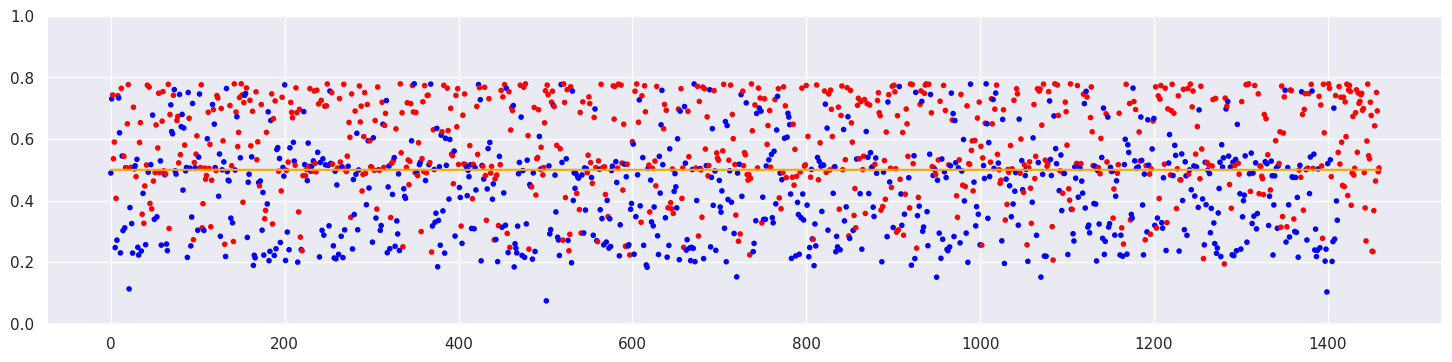

<Figure size 640x480 with 0 Axes>

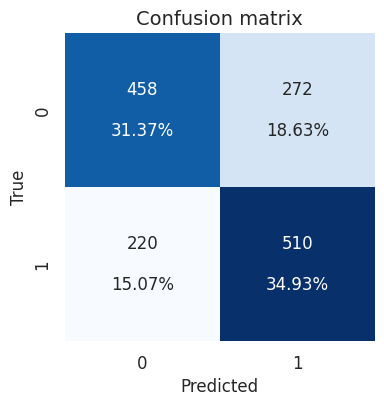

In [275]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=150, epochs=300

#### Create and train model

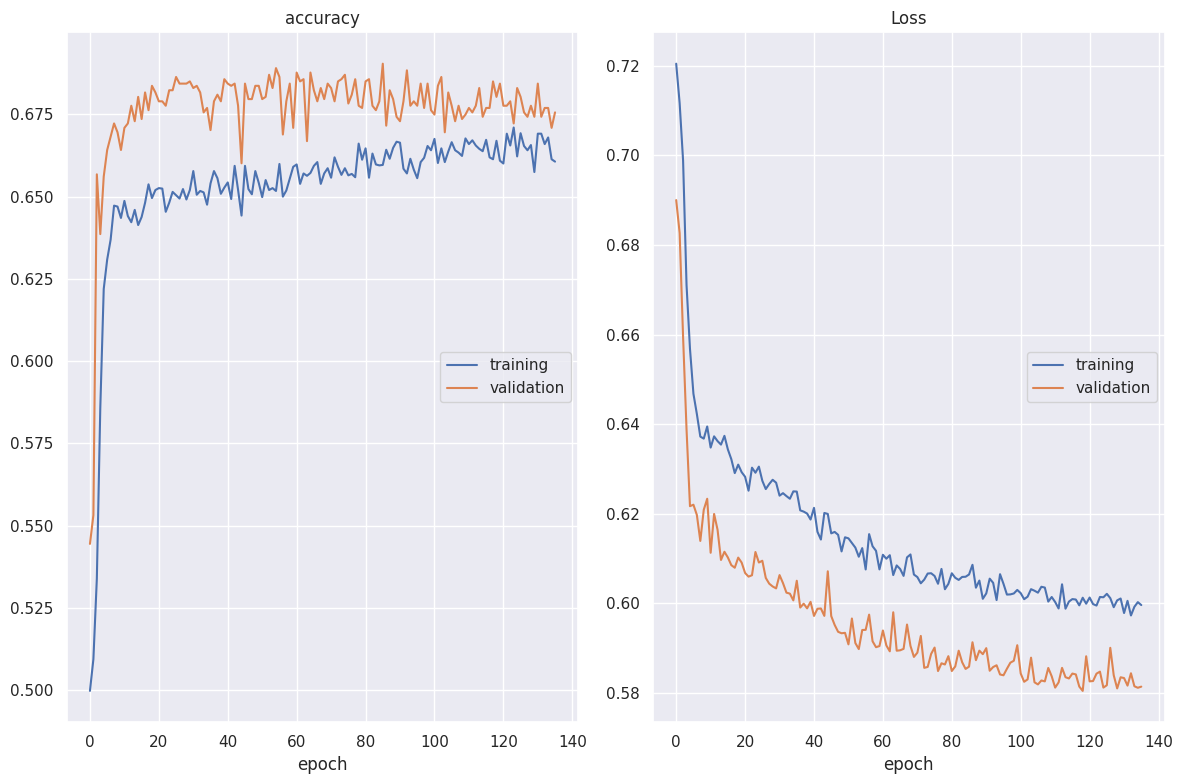

accuracy
	training         	 (min:    0.500, max:    0.671, cur:    0.661)
	validation       	 (min:    0.544, max:    0.690, cur:    0.676)
Loss
	training         	 (min:    0.597, max:    0.720, cur:    0.600)
	validation       	 (min:    0.580, max:    0.690, cur:    0.581)

Epoch 136: val_accuracy did not improve from 0.69044
47/47 [==============================] - 1s 18ms/step - loss: 0.5996 - accuracy: 0.6607 - val_loss: 0.5814 - val_accuracy: 0.6756


In [276]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v1_batch_size_150_only_import_feat_norm'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=150, epochs=300)

#### Prediction and results

Accuracy: 0.6719178082191781
Precision: [0.66277562 0.68214804]
Recall: 0.6438356164383562
F1 score: 0.662438
ROC AUC: 0.671918


(0.6719178082191781,
 array([0.66277562, 0.68214804]),
 0.6438356164383562,
 0.6624383368569414,
 0.671917808219178)

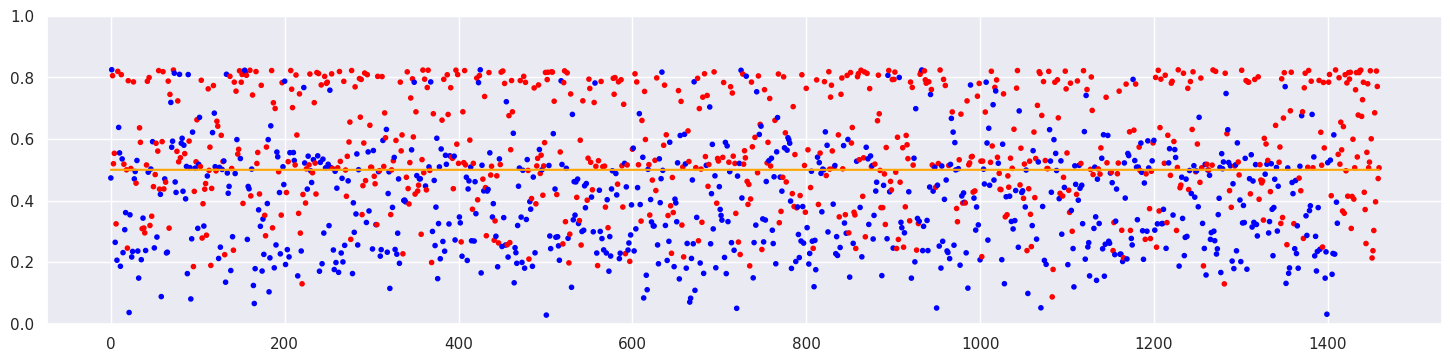

<Figure size 640x480 with 0 Axes>

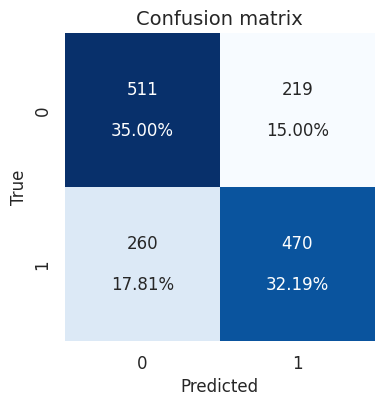

In [277]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=200, epochs=300

#### Create and train model

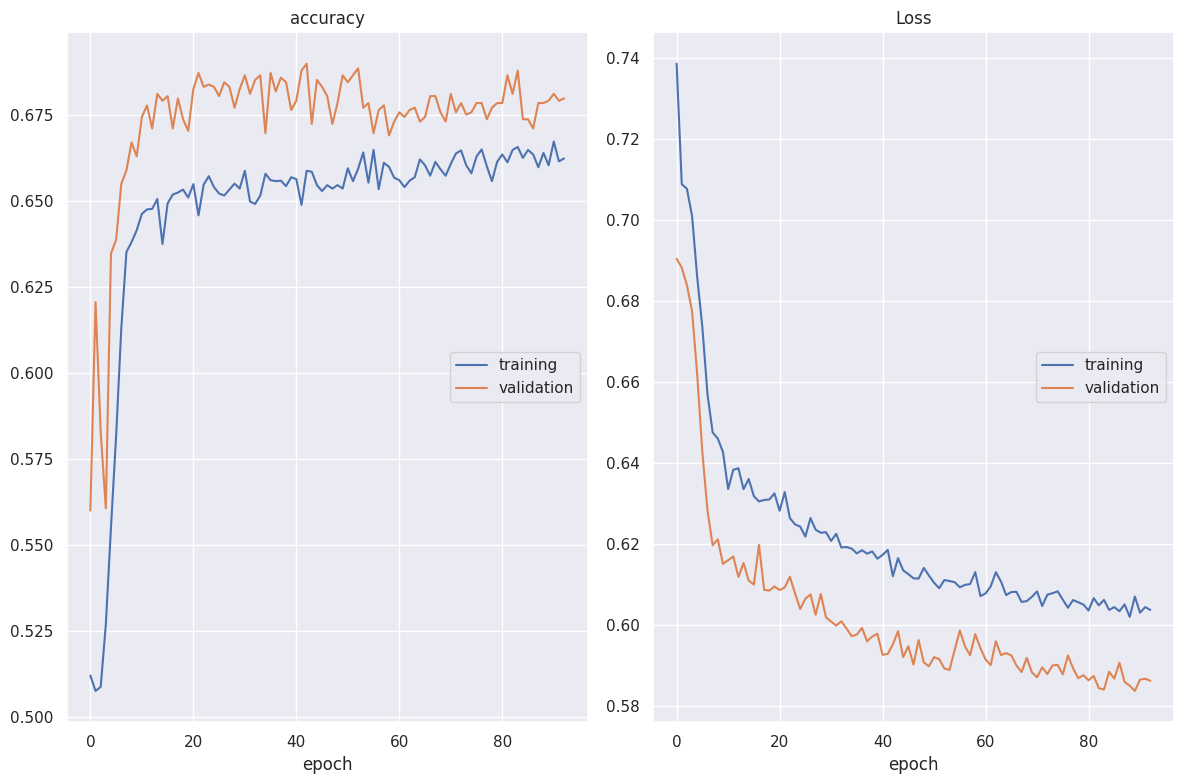

accuracy
	training         	 (min:    0.507, max:    0.667, cur:    0.662)
	validation       	 (min:    0.560, max:    0.690, cur:    0.680)
Loss
	training         	 (min:    0.602, max:    0.739, cur:    0.604)
	validation       	 (min:    0.584, max:    0.690, cur:    0.586)

Epoch 93: val_accuracy did not improve from 0.68977
35/35 [==============================] - 1s 21ms/step - loss: 0.6038 - accuracy: 0.6623 - val_loss: 0.5863 - val_accuracy: 0.6797


In [278]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v1_batch_size_200_only_import_feat_norm'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=200, epochs=300)

#### Prediction and results

Accuracy: 0.665068493150685
Precision: [0.68453292 0.64931846]
Recall: 0.7178082191780822
F1 score: 0.681848
ROC AUC: 0.665068


(0.665068493150685,
 array([0.68453292, 0.64931846]),
 0.7178082191780822,
 0.6818477553675993,
 0.665068493150685)

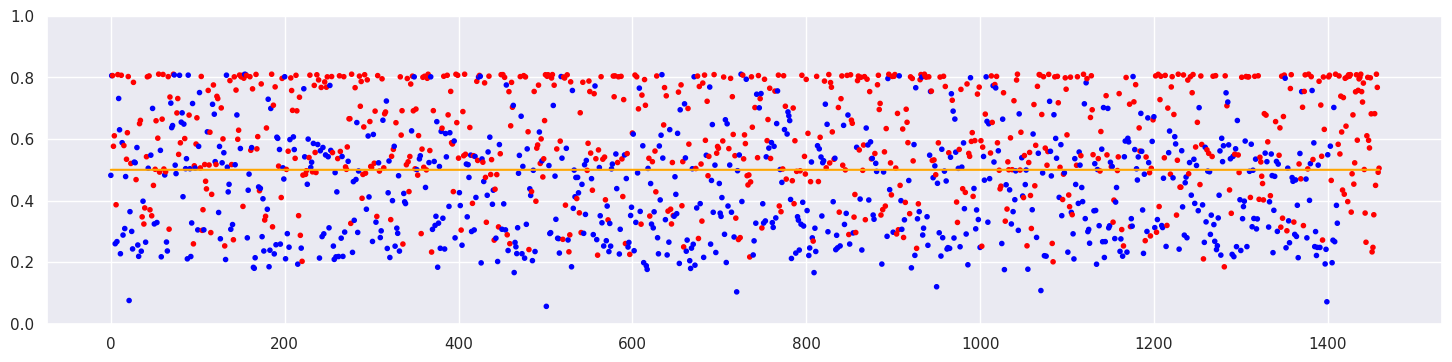

<Figure size 640x480 with 0 Axes>

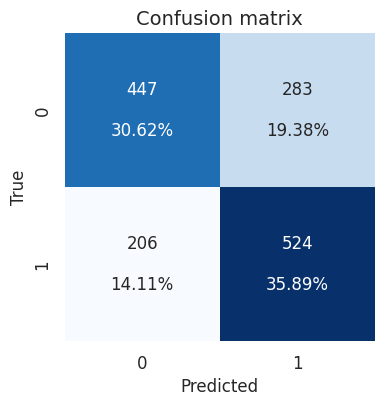

In [279]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=250, epochs=300

#### Create and train model

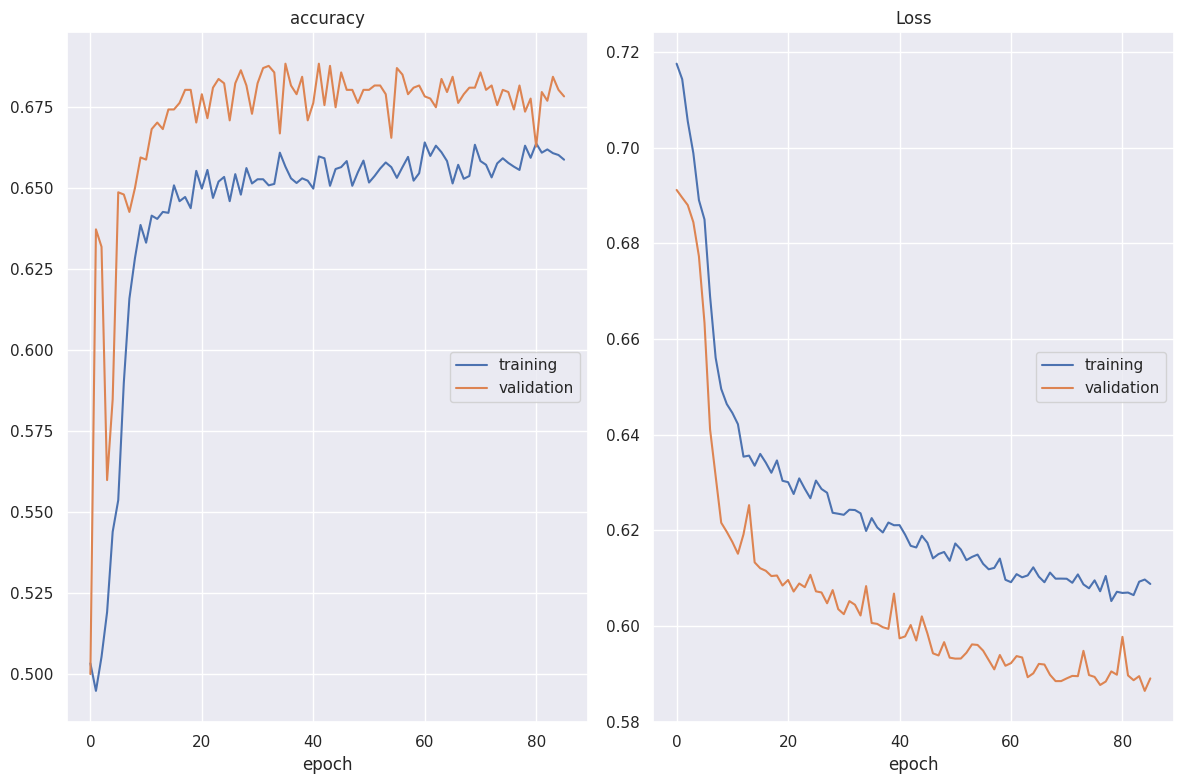

accuracy
	training         	 (min:    0.495, max:    0.664, cur:    0.659)
	validation       	 (min:    0.500, max:    0.688, cur:    0.678)
Loss
	training         	 (min:    0.605, max:    0.718, cur:    0.609)
	validation       	 (min:    0.586, max:    0.691, cur:    0.589)

Epoch 86: val_accuracy did not improve from 0.68843
28/28 [==============================] - 1s 26ms/step - loss: 0.6088 - accuracy: 0.6588 - val_loss: 0.5891 - val_accuracy: 0.6783


In [280]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v1_batch_size_250_only_import_feat_norm'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=250, epochs=300)

#### Prediction and results

Accuracy: 0.6643835616438356
Precision: [0.67391304 0.65584416]
Recall: 0.6917808219178082
F1 score: 0.673333
ROC AUC: 0.664384


(0.6643835616438356,
 array([0.67391304, 0.65584416]),
 0.6917808219178082,
 0.6733333333333335,
 0.6643835616438355)

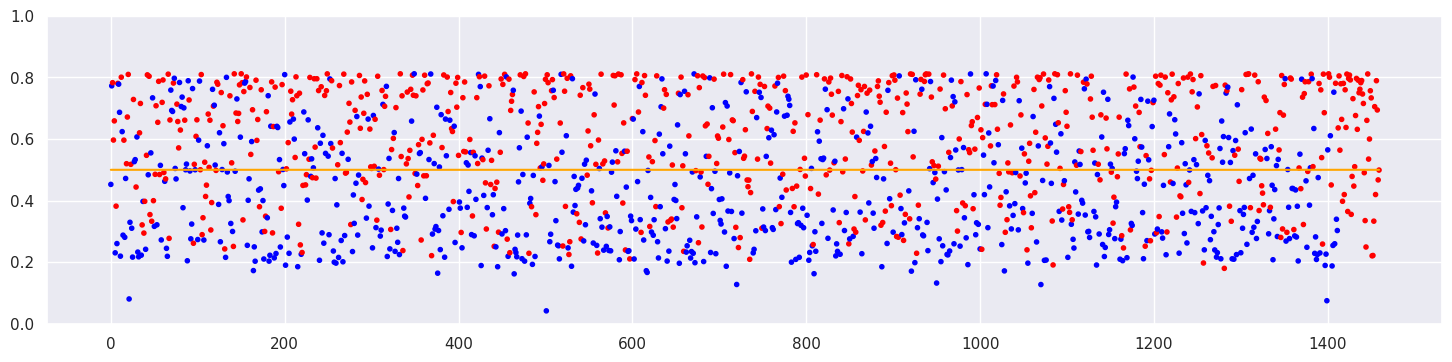

<Figure size 640x480 with 0 Axes>

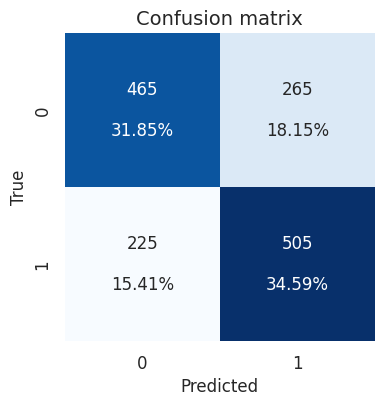

In [281]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### Model 1. - version for data reduced by outliers

### batch_size=10, epochs=300

#### Create and train model

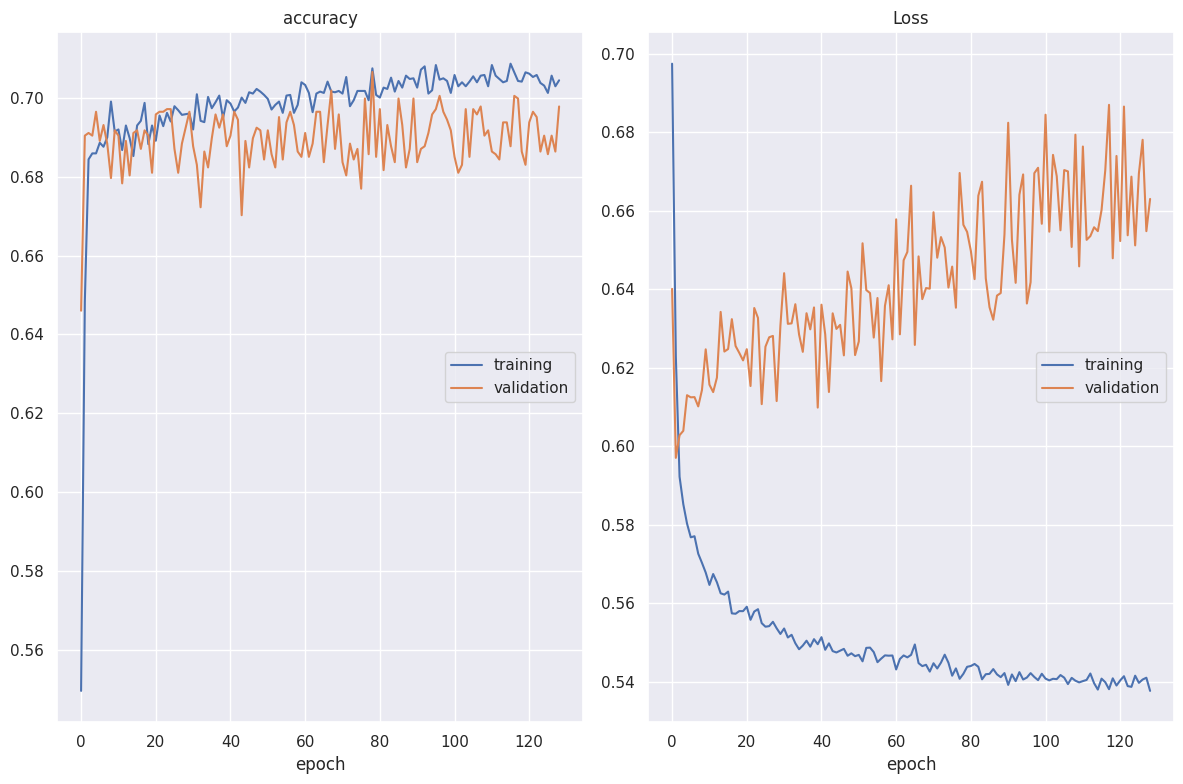

accuracy
	training         	 (min:    0.550, max:    0.709, cur:    0.704)
	validation       	 (min:    0.646, max:    0.707, cur:    0.698)
Loss
	training         	 (min:    0.538, max:    0.698, cur:    0.538)
	validation       	 (min:    0.597, max:    0.687, cur:    0.663)

Epoch 129: val_accuracy did not improve from 0.70659
594/594 [==============================] - 2s 4ms/step - loss: 0.5377 - accuracy: 0.7045 - val_loss: 0.6631 - val_accuracy: 0.6978


In [282]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v2_wo_outliers_batch_size_10_only_import_feat_norm'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=10, epochs=300)

#### Prediction and results

Accuracy: 0.6842465753424658
Precision: [0.67861886 0.69024045]
Recall: 0.6684931506849315
F1 score: 0.679193
ROC AUC: 0.684247


(0.6842465753424658,
 array([0.67861886, 0.69024045]),
 0.6684931506849315,
 0.6791927627000696,
 0.6842465753424657)

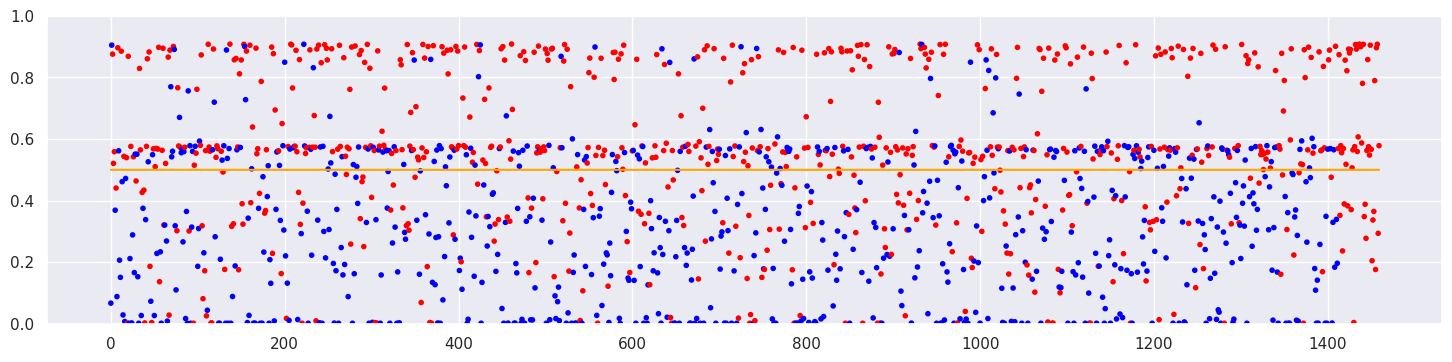

<Figure size 640x480 with 0 Axes>

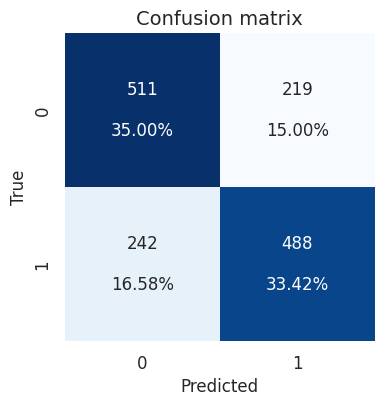

In [283]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=50, epochs=300

#### Create and train model

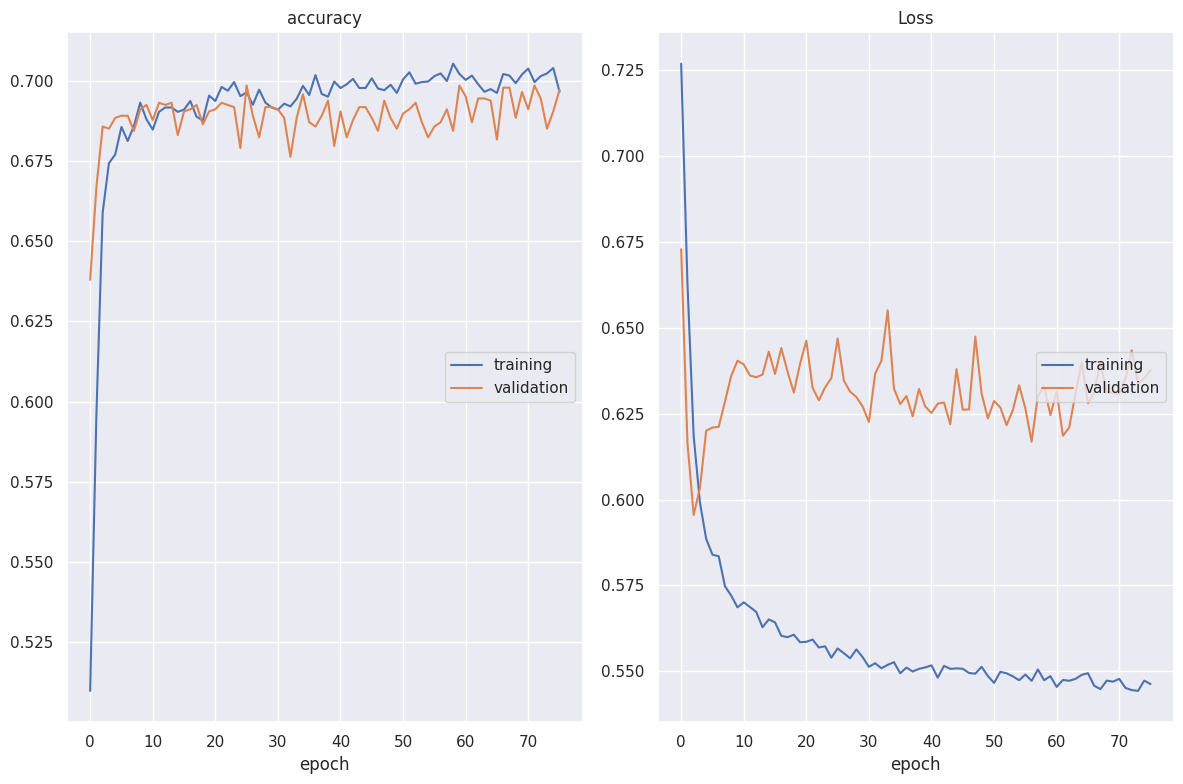

accuracy
	training         	 (min:    0.510, max:    0.705, cur:    0.697)
	validation       	 (min:    0.638, max:    0.699, cur:    0.697)
Loss
	training         	 (min:    0.544, max:    0.727, cur:    0.546)
	validation       	 (min:    0.596, max:    0.673, cur:    0.638)

Epoch 76: val_accuracy did not improve from 0.69852
119/119 [==============================] - 1s 9ms/step - loss: 0.5462 - accuracy: 0.6966 - val_loss: 0.6376 - val_accuracy: 0.6972


In [284]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v2_wo_outliers_batch_size_50_only_import_feat_norm'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=50, epochs=300)

#### Prediction and results

Accuracy: 0.6828767123287671
Precision: [0.68990043 0.67635403]
Recall: 0.7013698630136986
F1 score: 0.688635
ROC AUC: 0.682877


(0.6828767123287671,
 array([0.68990043, 0.67635403]),
 0.7013698630136986,
 0.6886348352387357,
 0.6828767123287671)

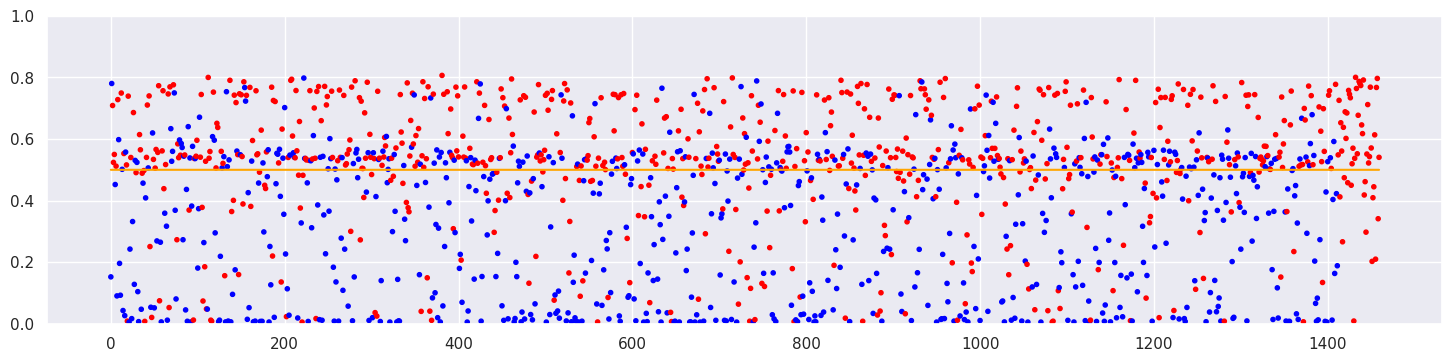

<Figure size 640x480 with 0 Axes>

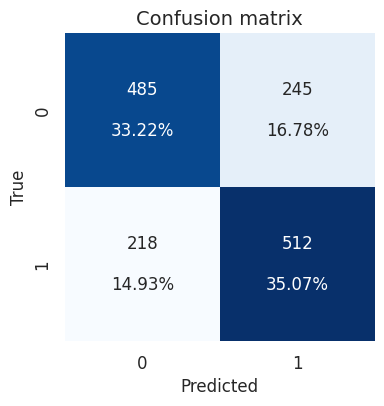

In [285]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=100, epochs=300

#### Create and train model

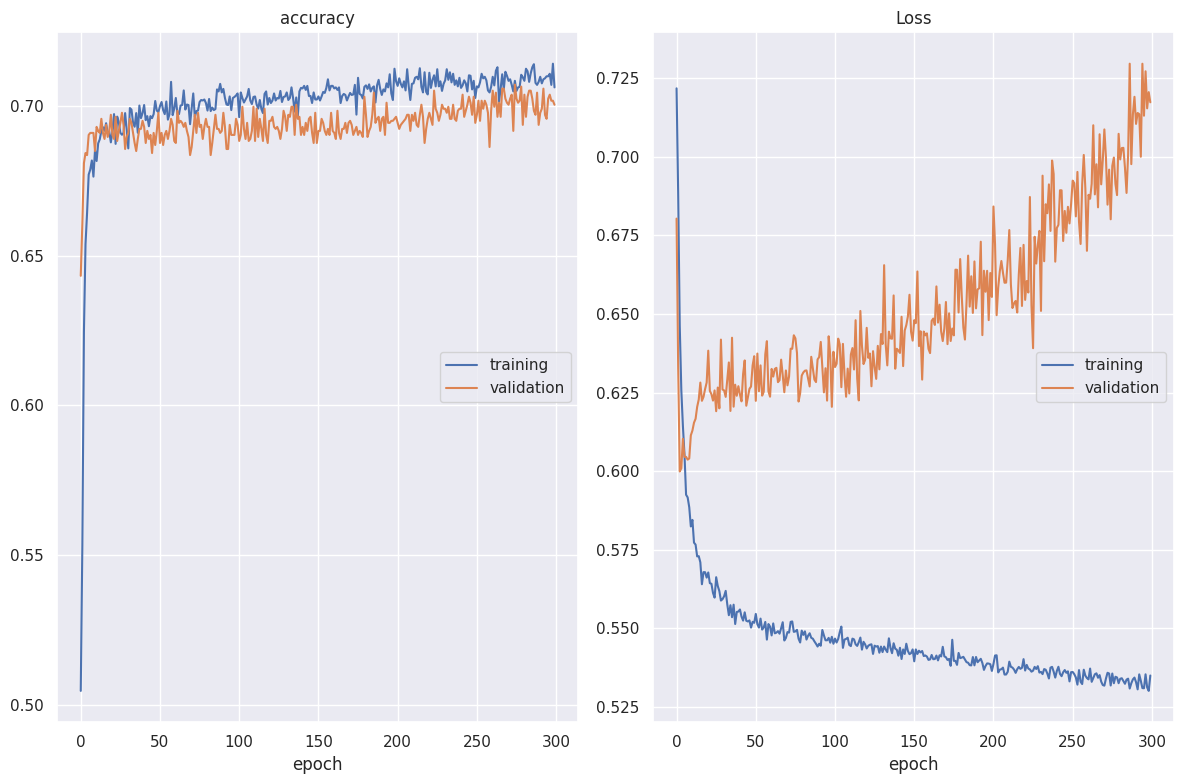

accuracy
	training         	 (min:    0.505, max:    0.714, cur:    0.706)
	validation       	 (min:    0.643, max:    0.707, cur:    0.701)
Loss
	training         	 (min:    0.530, max:    0.722, cur:    0.535)
	validation       	 (min:    0.600, max:    0.730, cur:    0.717)

Epoch 300: val_accuracy did not improve from 0.70727
60/60 [==============================] - 1s 14ms/step - loss: 0.5350 - accuracy: 0.7063 - val_loss: 0.7174 - val_accuracy: 0.7005


In [286]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v2_wo_outliers_batch_size_100_only_import_feat_norm'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=100, epochs=300)

#### Prediction and results

Accuracy: 0.6917808219178082
Precision: [0.71148036 0.6754386 ]
Recall: 0.7383561643835617
F1 score: 0.705497
ROC AUC: 0.691781


(0.6917808219178082,
 array([0.71148036, 0.6754386 ]),
 0.7383561643835617,
 0.705497382198953,
 0.6917808219178082)

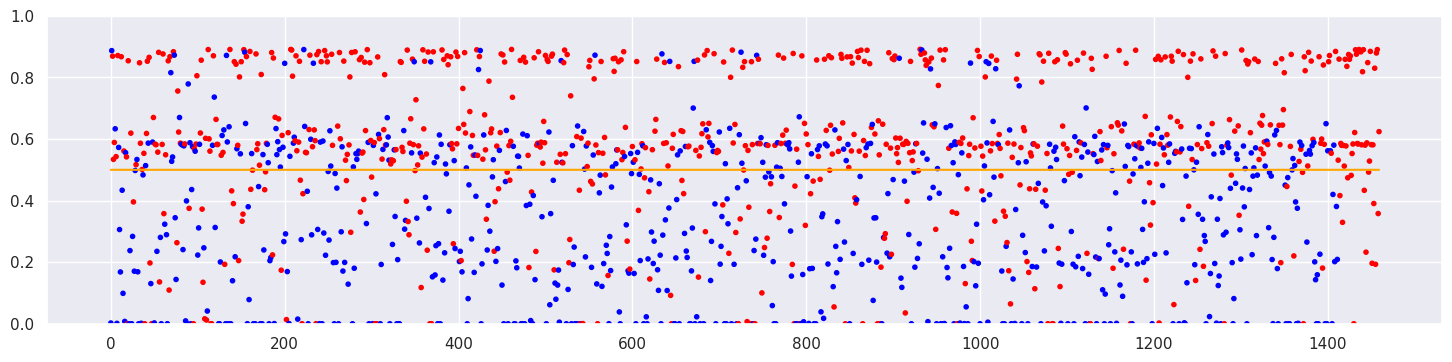

<Figure size 640x480 with 0 Axes>

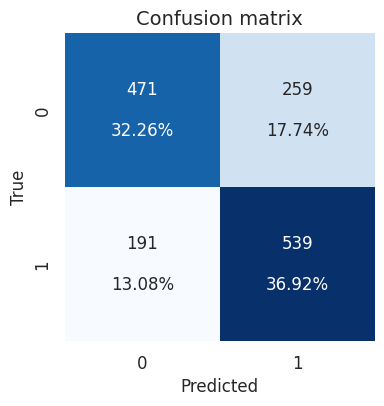

In [287]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=150, epochs=300

#### Create and train model

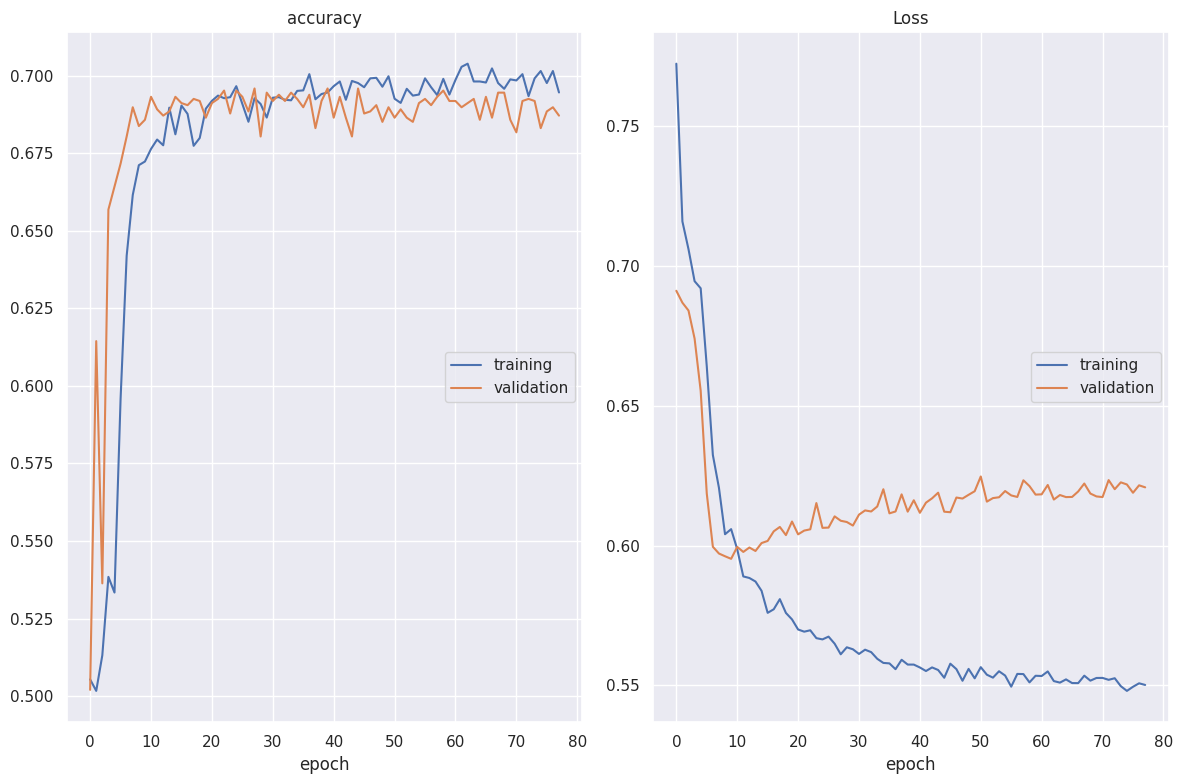

accuracy
	training         	 (min:    0.502, max:    0.704, cur:    0.695)
	validation       	 (min:    0.502, max:    0.696, cur:    0.687)
Loss
	training         	 (min:    0.548, max:    0.772, cur:    0.550)
	validation       	 (min:    0.595, max:    0.691, cur:    0.621)

Epoch 78: val_accuracy did not improve from 0.69583
40/40 [==============================] - 1s 21ms/step - loss: 0.5502 - accuracy: 0.6945 - val_loss: 0.6208 - val_accuracy: 0.6871


In [288]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v2_wo_outliers_batch_size_150_only_import_feat_norm'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=150, epochs=300)

#### Prediction and results

Accuracy: 0.6753424657534246
Precision: [0.70447284 0.65347722]
Recall: 0.7465753424657534
F1 score: 0.696931
ROC AUC: 0.675342


(0.6753424657534246,
 array([0.70447284, 0.65347722]),
 0.7465753424657534,
 0.6969309462915602,
 0.6753424657534247)

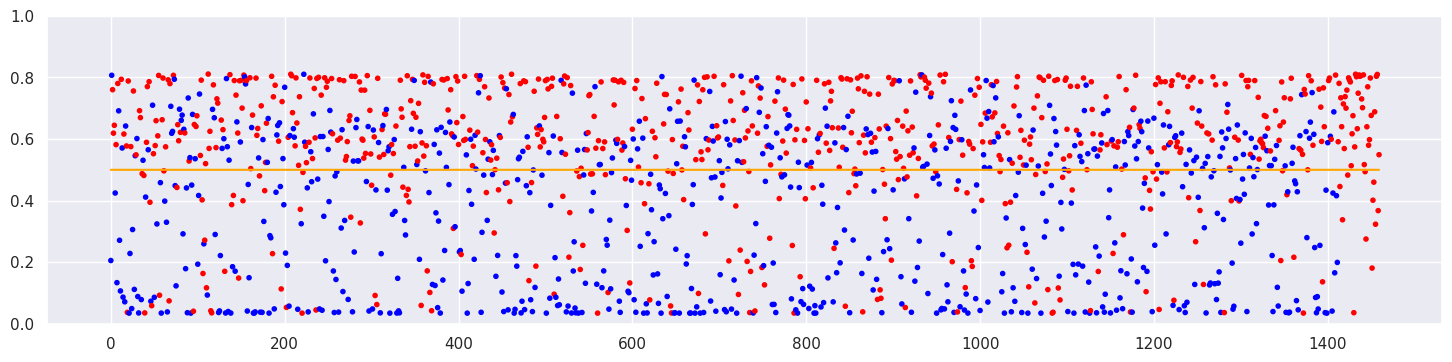

<Figure size 640x480 with 0 Axes>

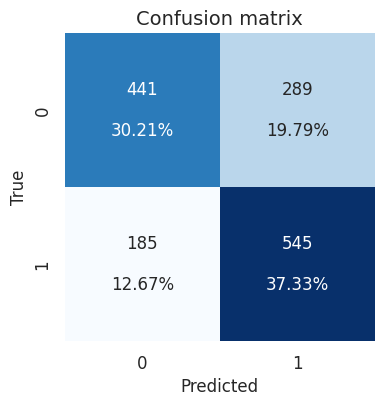

In [289]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=200, epochs=300

#### Create and train model

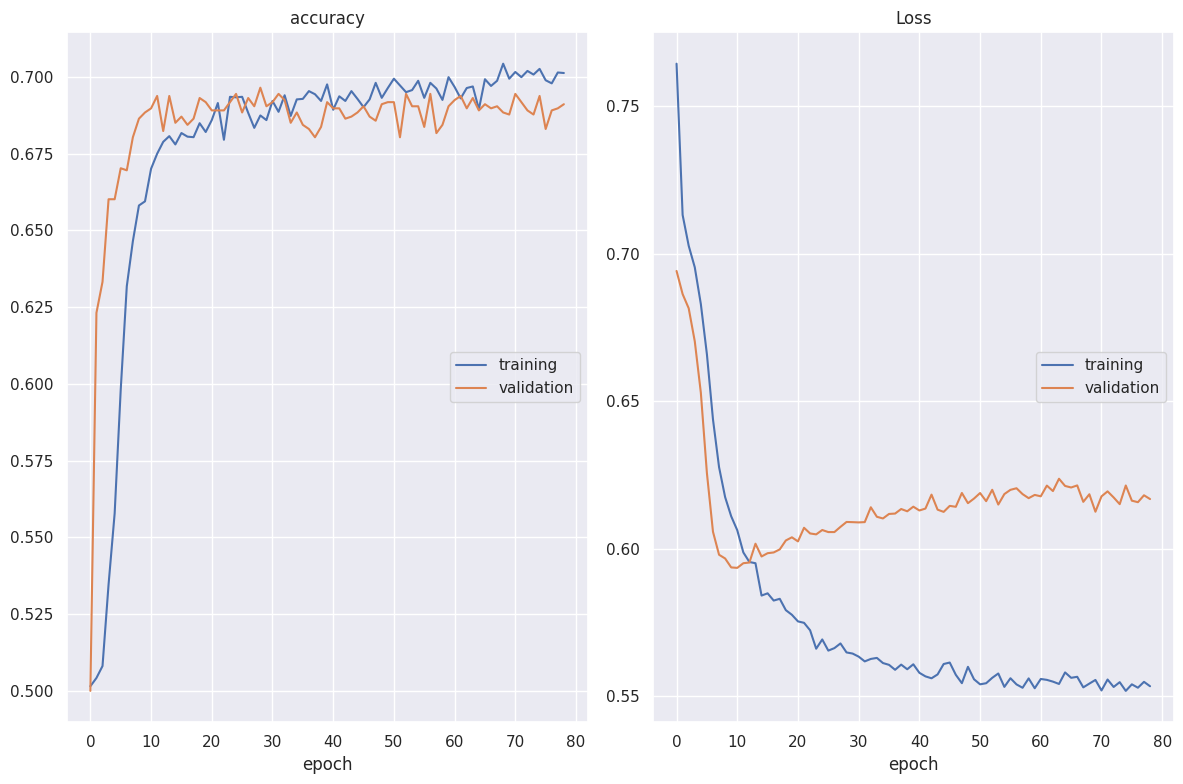

accuracy
	training         	 (min:    0.502, max:    0.704, cur:    0.701)
	validation       	 (min:    0.500, max:    0.697, cur:    0.691)
Loss
	training         	 (min:    0.552, max:    0.764, cur:    0.553)
	validation       	 (min:    0.594, max:    0.694, cur:    0.617)

Epoch 79: val_accuracy did not improve from 0.69650
30/30 [==============================] - 1s 26ms/step - loss: 0.5535 - accuracy: 0.7013 - val_loss: 0.6169 - val_accuracy: 0.6911


In [290]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v2_wo_outliers_batch_size_200_only_import_feat_norm'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=200, epochs=300)

#### Prediction and results

Accuracy: 0.6767123287671233
Precision: [0.6996904  0.65847666]
Recall: 0.7342465753424657
F1 score: 0.694301
ROC AUC: 0.676712


(0.6767123287671233,
 array([0.6996904 , 0.65847666]),
 0.7342465753424657,
 0.694300518134715,
 0.6767123287671233)

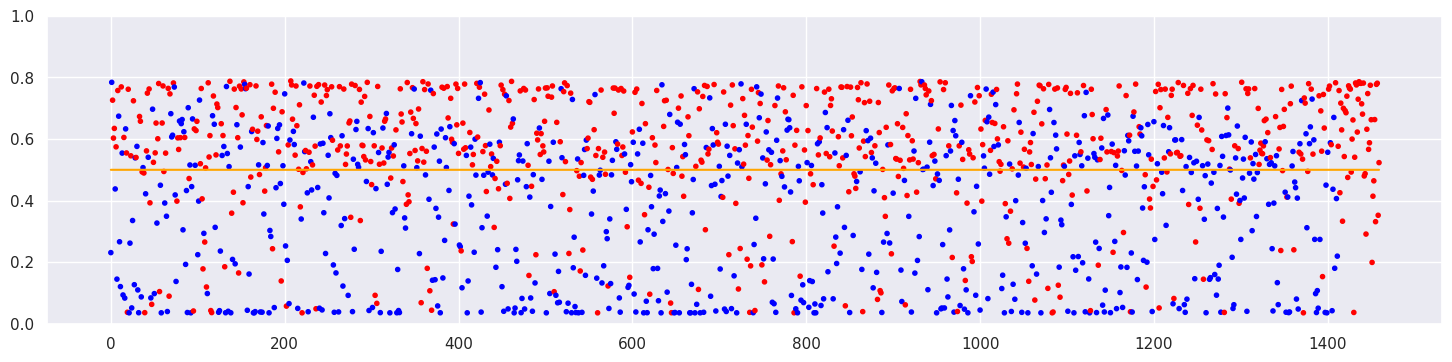

<Figure size 640x480 with 0 Axes>

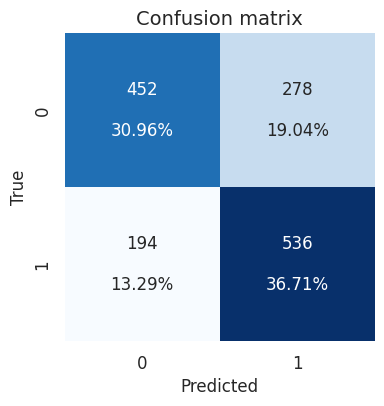

In [291]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=250, epochs=300

#### Create and train model

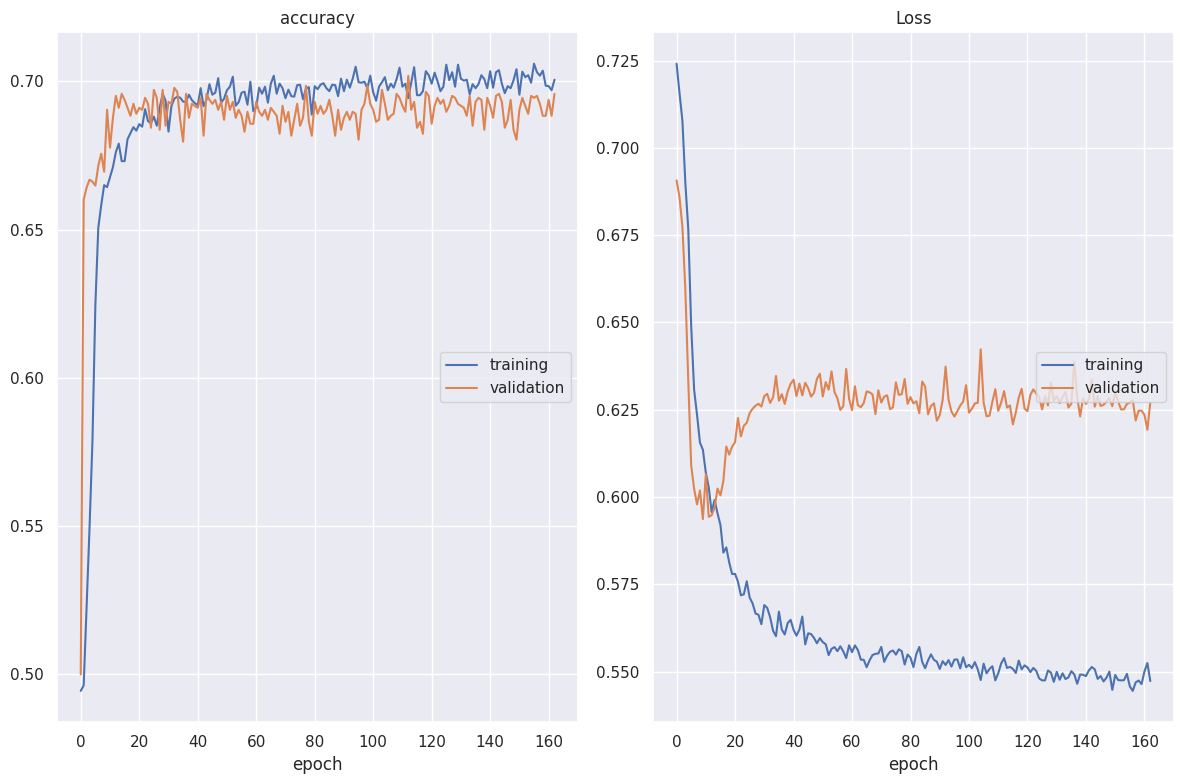

accuracy
	training         	 (min:    0.494, max:    0.706, cur:    0.701)
	validation       	 (min:    0.500, max:    0.702, cur:    0.696)
Loss
	training         	 (min:    0.544, max:    0.724, cur:    0.547)
	validation       	 (min:    0.594, max:    0.691, cur:    0.627)

Epoch 163: val_accuracy did not improve from 0.70188
24/24 [==============================] - 1s 32ms/step - loss: 0.5473 - accuracy: 0.7006 - val_loss: 0.6271 - val_accuracy: 0.6958


In [292]:
model_name = 'model_users_only_10000_with_location_mapped_to_country_1_v2_wo_outliers_batch_size_250_only_import_feat_norm'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=250, epochs=300)

#### Prediction and results

Accuracy: 0.6883561643835616
Precision: [0.70310192 0.67560664]
Recall: 0.7246575342465753
F1 score: 0.699273
ROC AUC: 0.688356


(0.6883561643835616,
 array([0.70310192, 0.67560664]),
 0.7246575342465753,
 0.6992729676140119,
 0.6883561643835616)

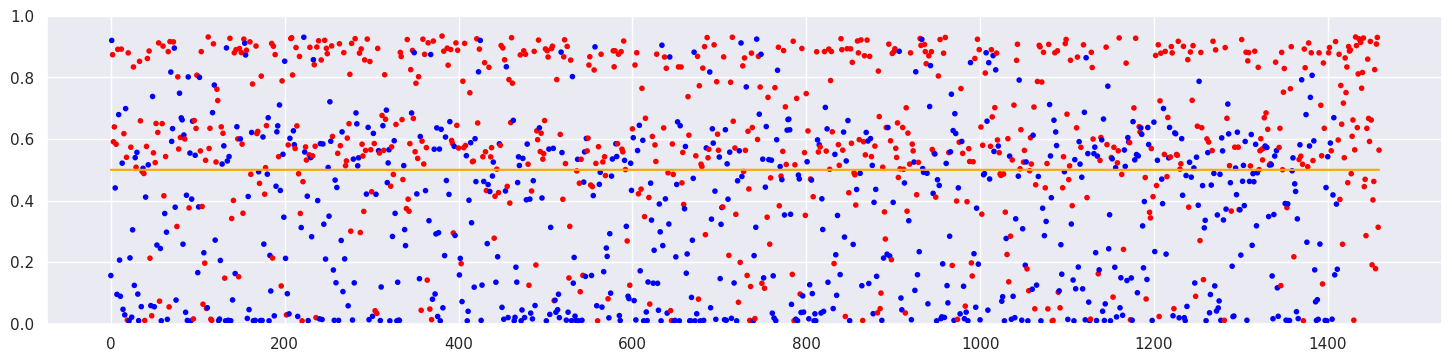

<Figure size 640x480 with 0 Axes>

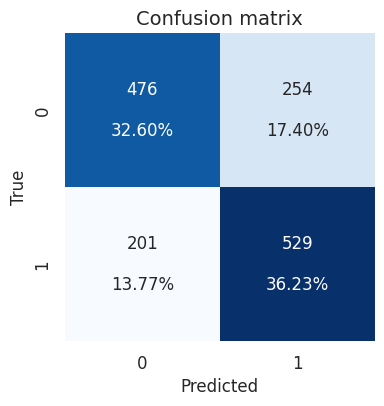

In [293]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)